# Проект №3. О вкусной и здоровой пище 
**Sergey Pinaev binom1982@gmail.com**<br>
**Ссылка на соревнование: [[SF-DST] Restaurant Rating prediction.](https://www.kaggle.com/c/sf-dst-restaurant-rating)**
### Описание
Дан датасет, содержащий сведения о 40 000 ресторанах Европы.
### Задачи
Произвести разведывательный анализ данных EDA и создать модель, которая должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.
### Описание датасета
1. **Restaurant_id** — идентификационный номер ресторана / сети ресторанов
2. **City** — город, в котором находится ресторан
3. **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане
4. **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города
5. **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель)
6. **Price Range** — диапазон цен в ресторане
7. **Number of Reviews** — количество отзывов о ресторане
8. **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана
9. **URL_TA** — URL страницы ресторана на TripAdvisor
10. **ID_TA** — идентификатор ресторана в базе данных TripAdvisor

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Отключаем ограничение при просмотре датасета на ширину столбцов и их количество
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('max_colwidth', -1)

ModuleNotFoundError: No module named 'numpy'

In [16]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

# Loading data

In [17]:
is_kaggle_or_github = False # в зависимости от использования kaggle или github, задается соответствующий путь к датасетам

if is_kaggle_or_github:
    # Выводим список файлов содержащийся в папке '/kaggle/input'
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


    DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
    df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
    df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
    sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

    # загружаем с собранной в ручную информацией о городах
    # столбцы оставлю на русском иначе запутаюсь!
    df_city_additional_information = pd.read_csv('/kaggle/input/d/binom82/city-info/city_info_utf8.csv', sep=';')

    # загружаем датесет где для каждого отзыва посчитана тональнасть на основании статьи https://www.youtube.com/watch?v=NPJ1kF-63VI
    df_reviews_with_sentiment = pd.read_csv('/kaggle/input/reviews-with-sentiment/reviews_with_sentiment.csv')
else: 
    df_train = pd.read_csv('data/main_task.csv')
    df_test = pd.read_csv('data/kaggle_task.csv')
    sample_submission = pd.read_csv('data/sample_submission.csv')

    # загружаем с собранной в ручную информацией о городах
    # столбцы оставлю на русском иначе запутаюсь!
    df_city_additional_information = pd.read_csv('data/city_info_utf8.csv', sep=';')

    # загружаем датесет где для каждого отзыва посчитана тональнасть на основании статьи https://www.youtube.com/watch?v=NPJ1kF-63VI
    df_reviews_with_sentiment = pd.read_csv('data/reviews_with_sentiment.csv')

In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['is_train'] = True # помечаем где у нас трейн
df_test['is_train'] = False # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   is_train           50000 non-null  bool   
 10  Rating             50000 non-null  float64
dtypes: bool(1), float64(3), object(7)
memory usage: 3.9+ MB


None

# Functions

In [19]:
def show_dataset_info(row_count = 5, is_sample = True, is_info = True):
    '''Отображает первые n - строе и информацию о столбцах'''
    if is_sample:
        display(data.sample(row_count))
    else:
        display(data.head(row_count))
     
    if is_info:
        display(data.info())


def get_cuisine_style_list(value):
    '''Преобразует кухни в список'''
    if value is not np.nan:
        return [y.strip(" '").lower() for y in value[1:-1].split(',')]    
    else:
        return value
    

def list_of_lists_to_list(value):
    '''Преобразует список саписков в список'''
    return  [item  for sublist in value for item in sublist]
    

def scatter_for_two_columns_with_count(dataset, value_x, value_y, figsize=(25,40)):
    '''Строит график зависимости x от y с цветовым количественным показателем'''
    dataset_group = dataset.groupby([value_x, value_y]).size().to_frame('count').reset_index()
    dataset_group.sort_values(by='count', ascending=False, inplace=True)
    # display(dataset_group)

    plt.figure(figsize=figsize)
    plt.xticks(rotation='vertical')
    # dataset_group = dataset_group[dataset_group['count'] > 10]
    plt.scatter(dataset_group[value_x],dataset_group[value_y],dataset_group['count'], c=np.random.rand(dataset_group.shape[0]));
    plt.tight_layout()
    

def outliers_z_score_index(ys, threshold=3):
    '''Поиск выбросов по отклонению (z-score)'''
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = pd.Series([np.abs((value - mean_y) / std_y) for index, value in ys.items()], index=[index for index, value in ys.items()])
    # print(z_scores)
    return z_scores[z_scores > threshold].index


def reviews_column_convert(value):
    '''Парсим признак reviews и возвращаем список содержащий дату и номер дату публикации.
    Представим данный признак в виде 4 признаков: 
    review_1_text, review_1_date, review_2_text, review_2_date 
    '''
    
    if pd.isna(value):
        return value
    
    # очищаем кавычки и возможные пробелы в переди и начале текса
    review_text_list = [ [z.strip(" '") for z in y.split("', '")] for y in value[2:-2].split('], [')]
    
    # review_1_text, review_2_text, review_1_date, review_2_date 
    result_list = [np.nan for i in range(4)]
    
    if len(review_text_list[0]) == 2:
#         result_list[0:2] = review_text_list[0]
#         result_list[2:2] = review_text_list[1]
        result_list[0] = review_text_list[0][0]
        result_list[1] = review_text_list[0][1]
        result_list[2] = review_text_list[1][0]
        result_list[3] = review_text_list[1][1]
    elif len(review_text_list[0]) == 1:
        result_list[0] = review_text_list[0][0]
        result_list[2] = review_text_list[1][0]

#     result_list[4] = len(review_text_list) 
    # print(result_list[4])
    # на всякий пожарный сохраним длину списка отзывов, а то вдруг ошибка при парсинге
   
    # print(result_list[4])
    # print(review_text_list, len(review_text_list), len(review_text_list[0]), len(review_text_list[1]), review_text_list[0][:2], review_text_list[1][:2])     
    return result_list
    
    
def round_to_rating_1(number):
    '''Округляем до 0.5 (банковское округление)'''
    return np.round(number * 2) / 2


def round_to_rating_2(value):
    '''Округляем до 0.5 (обычное человеческое округление в большую или меньшую строну)'''
    value1 = value % 1
#     print(value1)
    if value1 < 0.25:
        value -=  value1
    elif value1 < 0.5:
        value -=  value1 - 0.5
    elif value1 < 0.75:
        value -=  value1 - 0.5
    else:
        value -=  value1 - 1    
    return value

# Data Preprocessing

In [20]:
# переименовываем столбы датасета
data.columns = data.columns.map(lambda x: x.lower().replace(' ','_'))
show_dataset_info()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating
8858,id_8858,Paris,NaN,8375.0,NaN,7.0,"[['great for take-away'], ['06/25/2017']]",/Restaurant_Review-g187147-d12593522-Reviews-Mamy_Therese-Paris_Ile_de_France.html,d12593522,False,0.0
36782,id_2716,Lisbon,"['Healthy', 'Gluten Free Options']",2719.0,$,9.0,"[['Good selection, great service, delicious'], ['04/21/2017']]",/Restaurant_Review-g189158-d8422580-Reviews-Myiced_Benfica-Lisbon_Lisbon_District_Central_Portugal.html,d8422580,True,4.5
4776,id_4776,Barcelona,"['Steakhouse', 'Spanish']",4280.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187497-d11638928-Reviews-El_Raco_del_Camp-Barcelona_Catalonia.html,d11638928,False,0.0
5087,id_5087,Prague,NaN,2496.0,NaN,2.0,"[['Great restaurant for take away', 'Very good Indian food'], ['07/01/2017', '04/29/2017']]",/Restaurant_Review-g274707-d12186041-Reviews-Hurry_Curry_indian_restaurant-Prague_Bohemia.html,d12186041,False,0.0
32934,id_3607,Berlin,NaN,3609.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d12654085-Reviews-Jamoneria-Berlin.html,d12654085,True,5.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   is_train           50000 non-null  bool   
 10  rating             50000 non-null  float64
dtypes: bool(1), float64(3), object(7)
memory usage: 3.9+ MB


None

# Cleaning and Prepping Data

### Распределение числовых признаков

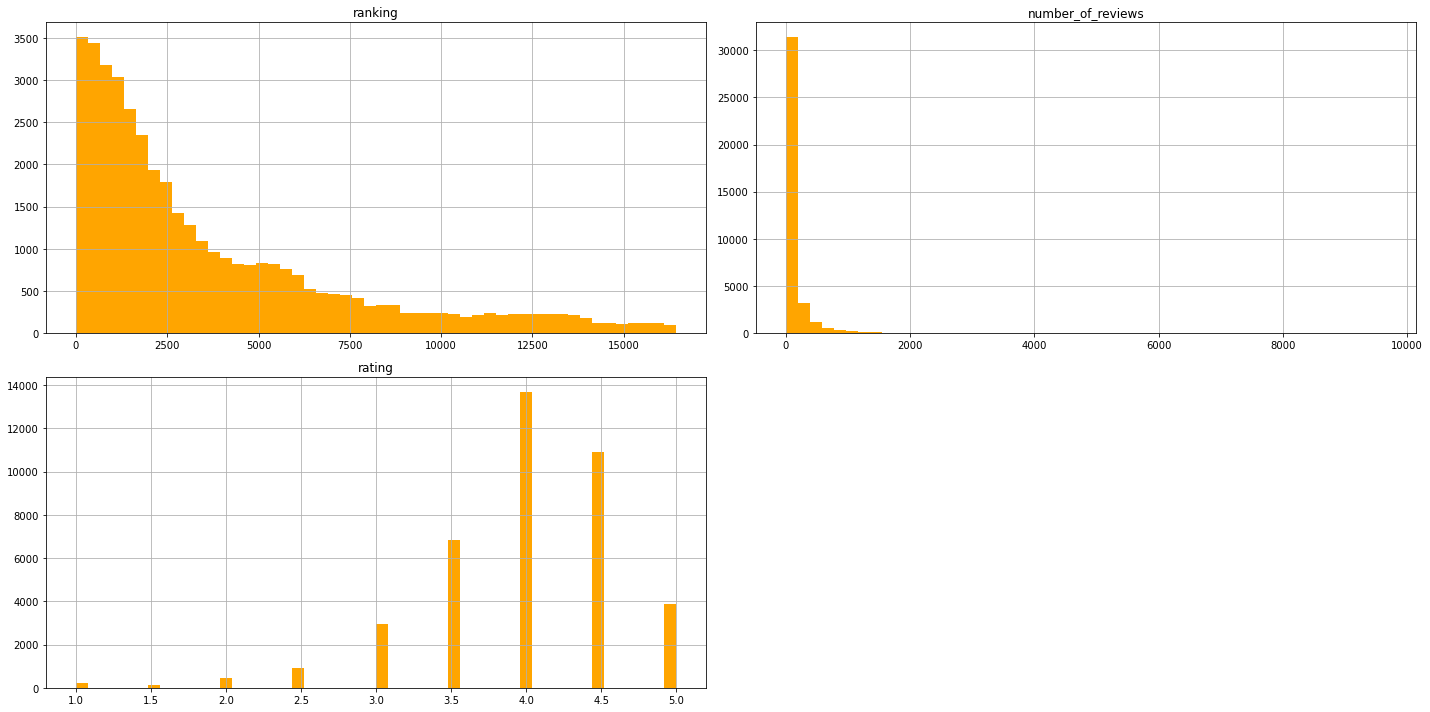

In [21]:
# посмотрим на распределение числовых признаков в датасете
numerical_features = data.select_dtypes(include='number').columns

data[data.is_train][numerical_features].hist(figsize=(20,10), bins=50, color=['orange'], log = False); # прологарифмируем, чтобы лучше было видно выбросы
plt.tight_layout()

### Обработка признаков

In [22]:
# посмотрим на количество уникальные значения
data.nunique(dropna=False)

restaurant_id        13094
city                 31   
cuisine_style        10732
ranking              12975
price_range          4    
number_of_reviews    1574 
reviews              41858
url_ta               49963
id_ta                49963
is_train             2    
rating               10   
dtype: int64

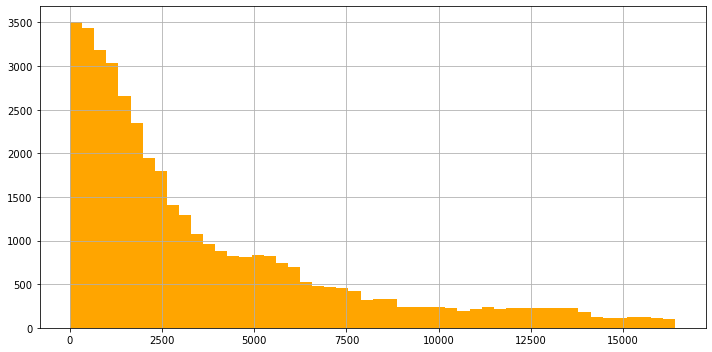

In [23]:
# 1) restaurant_id - [nan: no]

data[data.is_train]['restaurant_id'].apply(lambda x: x.replace('id_','')).astype(int).hist(figsize=(10,5), bins=50, color=['orange'], log = False);
plt.tight_layout()

# значения признака не уникальны
# display(data[data.is_train]['restaurant_id'].value_counts(dropna=False).reset_index())

data['restaurant_id'] = data['restaurant_id'].apply(lambda x: x.replace('id_','')).astype(int)
# вывод: restaurant_id очень похож на ranking. Скорее всего restaurant_id - это id ресторана в пределах одного города

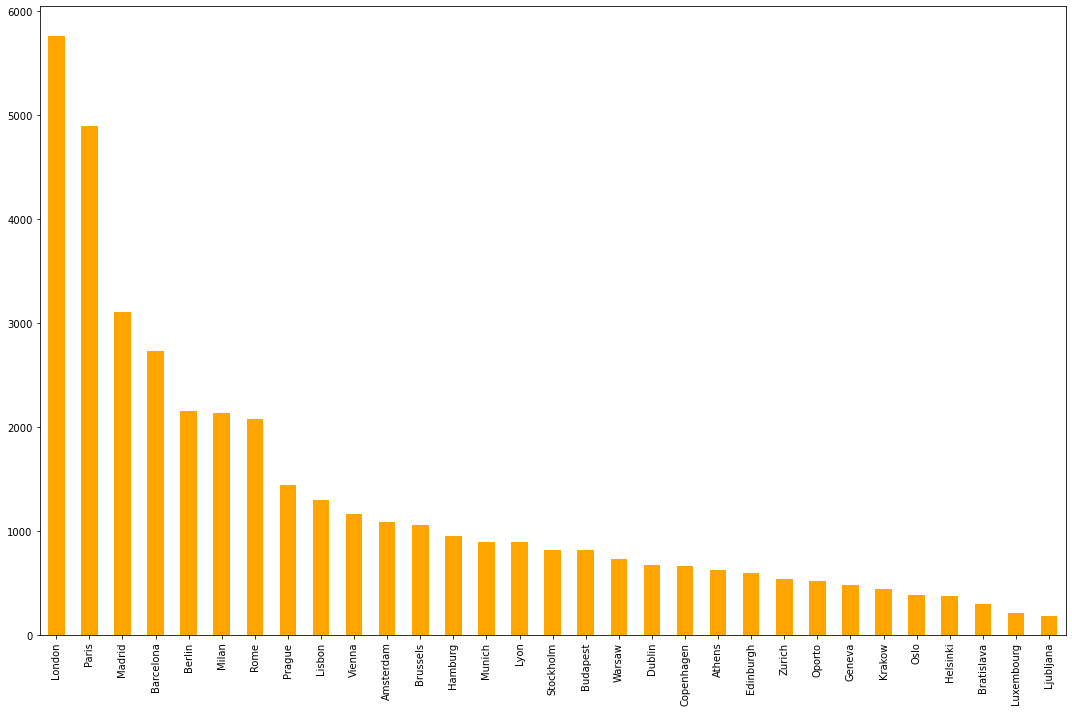

In [24]:
# 2) city - [nan: no]
data[data.is_train]['city'].value_counts(dropna=False).plot(kind='bar', figsize=(15,10), color=['orange']);
plt.tight_layout()
data.city = data.city.str.lower()

data['city_hash']= data['city'].apply(lambda x: hash(x)) 
# data.sample(5)
# вывод: city - это категориальный признак, позже создадим из него dummies признак

### Загрузим дополнительную информацию о городах

In [25]:
# столбцы оставлю на русском иначе запутаюсь!
# переименовываем столбы датасета
df_city_additional_information.columns = df_city_additional_information.columns.map(lambda x: x.lower().replace(' ','_'))
df_city_additional_information.drop(['№','число_ресторанов'], axis=1, inplace=True)
# display(df_city_additional_information.sample(5))


df_city_additional_information['город'] = df_city_additional_information['город'].str.lower().str.strip(' \t')
df_city_additional_information['страна'] = df_city_additional_information['страна'].str.lower().str.strip(' \t')

# заменим yes - 1, no -0
dict_nums = {'столица': {"yes": 1, "no": 0}, 'евросоюз': {"yes": 1, "no": 0}}
df_city_additional_information.replace(dict_nums, inplace=True)

#заменим пропуски
df_city_additional_information['ввп_на_душу_населения_доллары_2018_год'].fillna(round(df_city_additional_information['ввп_на_душу_населения_доллары_2018_год'].mean()), inplace=True)

# конвертируем строковые признаки в числовые
# df_city_additional_information.select_dtypes(include=['object','bool']).columns
# object_features = ['население_мил_чел', 'площадь_км2', 'среднегодовая_температура_цельсий']
# df_city_additional_information[object_features] = df_city_additional_information[object_features].apply(lambda x:  x.apply(lambda y: y.replace(',','.')))
# df_city_additional_information[object_features] = df_city_additional_information[object_features].astype(float)

# df_city_additional_information = pd.get_dummies(df_city_additional_information, columns=['страна'], dummy_na=False)


# data.city = data.city.str.lower()
# df_reviews_with_sentiment.rename(columns = {'review_2_sentiment_mean' : 'reviews_is_positive'}, inplace = True)
# # display(df_reviews_with_sentiment.sample(5))

# # объединяем датасеты
# data = pd.concat([data, df_reviews_with_sentiment['reviews_is_positive']],  axis=1, sort=False)
# object_features = data[data.is_train].select_dtypes(include=['object','bool']).columns
# # x = pd.concat([data, df_reviews_with_sentiment],  axis=1, sort=False)
display(df_city_additional_information.info())
display(df_city_additional_information.sample(5))

data = data.merge(df_city_additional_information, left_on='city', right_on='город').drop(['город'], axis=1)
display(data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   город                                   31 non-null     object 
 1   страна                                  31 non-null     object 
 2   столица                                 31 non-null     int64  
 3   население_мил_чел                       31 non-null     float64
 4   площадь_км2                             31 non-null     float64
 5   плотность_населения_чел/км2             31 non-null     int64  
 6   высота_нум_метров                       31 non-null     int64  
 7   среднегодовая_температура_цельсий       31 non-null     float64
 8   среднее_количество_осадков_ммвгод       31 non-null     int64  
 9   ввп_на_душу_населения_доллары_2018_год  31 non-null     float64
 10  евросоюз                                31 non-null     int64  


None

,город,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз
16,budapest,hungary,1,1.7,525.2,3330,108,11.1,661,46131.0,1
21,edinburgh,scotland,1,0.5,118.0,4140,47,8.3,868,59394.0,0
2,madrid,spain,1,3.2,604.3,5380,667,14.5,415,50434.0,1
8,lisbon,portugal,1,0.5,100.0,5047,2,16.7,591,41174.0,1
26,oslo,norway,1,0.7,454.0,1483,23,5.9,1010,65647.0,0


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз
15465,2740,lisbon,NaN,2743.0,NaN,15.0,"[['nice bar', 'Nice atmosphere in the bar'], ['12/11/2014', '07/31/2014']]",/Restaurant_Review-g189158-d2615769-Reviews-Le_Ganesh-Lisbon_Lisbon_District_Central_Portugal.html,d2615769,True,4.0,-6124226141940569513,portugal,1,0.5,100.0,5047,2,16.7,591,41174.0,1
20481,1928,rome,"['Italian', 'Bar', 'Pub', 'Brew Pub']",1929.0,$$ - $$$,157.0,"[['As expected', 'Burger is not so good'], ['01/07/2016', '09/29/2015']]",/Restaurant_Review-g187791-d6598387-Reviews-La_Carrozzeria_Beer_Food-Rome_Lazio.html,d6598387,True,4.5,-4781955370843492607,italy,1,2.8,1285.0,2229,52,15.8,878,59394.0,1
14946,1231,lisbon,"['Pizza', 'European', 'Italian', 'Indian', 'Mediterranean', 'Portuguese', 'Vegan Options', 'Vegetarian Friendly']",1302.0,$$ - $$$,16.0,"[['Aussies on holiday', 'very good'], ['05/22/2017', '02/10/2017']]",/Restaurant_Review-g189158-d10226471-Reviews-Restaurante_A_Ponte-Lisbon_Lisbon_District_Central_Portugal.html,d10226471,False,0.0,-6124226141940569513,portugal,1,0.5,100.0,5047,2,16.7,591,41174.0,1
41749,2674,berlin,NaN,2676.0,NaN,10.0,"[['Traditional german fayre', 'Cash only'], ['09/07/2017', '08/04/2016']]",/Restaurant_Review-g187323-d5982084-Reviews-Zum_Alten_Krug-Berlin.html,d5982084,True,4.5,7790727686081383775,germany,1,3.6,891.8,4463,34,10.1,669,45311.0,1
44804,1090,athens,['Greek'],1092.0,NaN,NaN,"[['Absolutely amzing'], ['11/04/2016']]",/Restaurant_Review-g189400-d11779008-Reviews-Mezoura-Athens_Attica.html,d11779008,True,5.0,7301922862369855506,greece,1,3.0,412.0,7500,71,17.5,378,59394.0,1


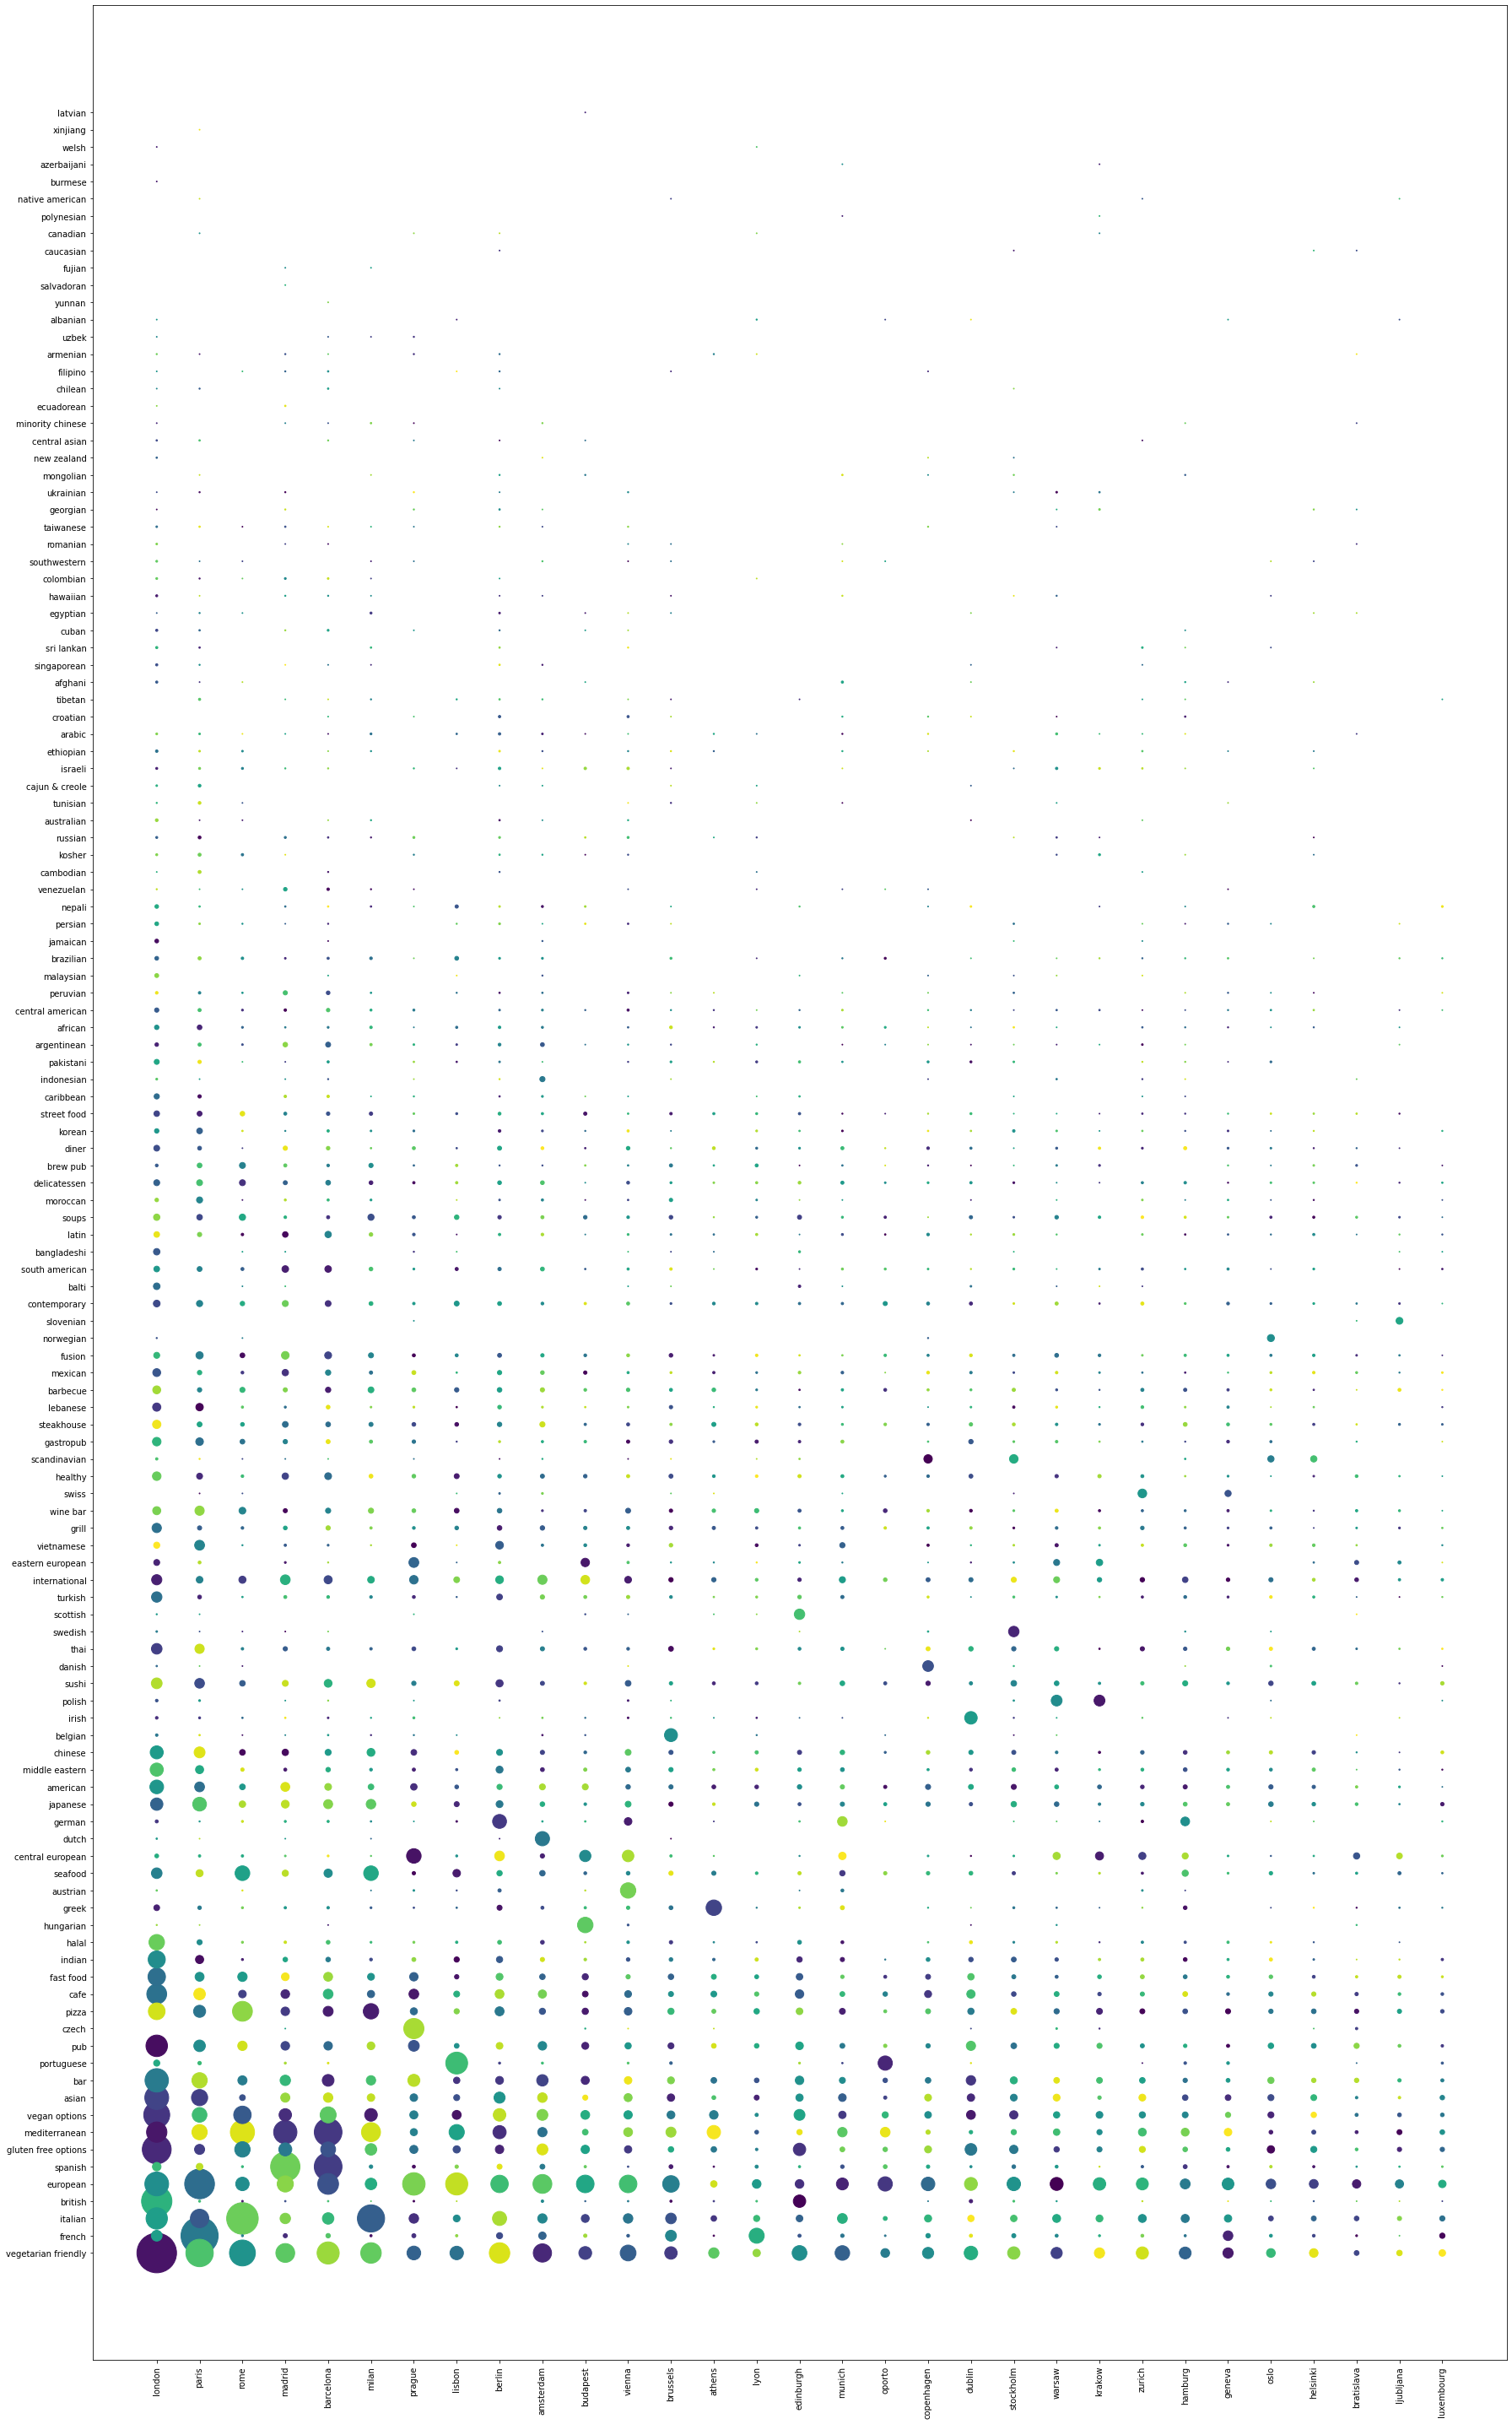

In [26]:
# 3) cuisine_style - [nan: no]
# парсим текстовые значения 'cuisine_style' в список значений
data['cuisine_style'] = data['cuisine_style'].map(get_cuisine_style_list)

# посмотрим на распределение кухонь в каждом городе
df_city_cuisine = data[data.is_train &  ~data['cuisine_style'].isna()][['city', 'cuisine_style']].explode('cuisine_style')
scatter_for_two_columns_with_count(df_city_cuisine, 'city', 'cuisine_style')

In [27]:
# вычислим самую популярную кухню в городе и заполним ей пустые значения
for city in set(data['city'].value_counts().index): 
    cuisine_of_city = data[data.is_train & (data['city'] == city)]['cuisine_style'].reset_index()
    # самая популярная кухня в городе
    freq_cuisine_of_city = cuisine_of_city.explode('cuisine_style')['cuisine_style'].mode(dropna=True)
#     print(freq_cuisine_of_city, type(freq_cuisine_of_city))
    data.loc[(data['city'] == city) & (pd.isna(data['cuisine_style'])), 'cuisine_style'] = [freq_cuisine_of_city]

# это прям реально какойто костыль, тк я не знаю способа присвоить отфильрованным данным список
data['cuisine_style'] = data['cuisine_style'].apply(lambda x: x if isinstance(x, list) else [x])

# количество кухонь в ресторане
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x)) 
display(data.info())
# display(data.sample(5))

ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [14]:
# Найдем значения описывающие 90% всех значений
cuisine_style_element_series = data[['cuisine_style']].explode('cuisine_style')['cuisine_style']
cuisine_style_value_counts = cuisine_style_element_series.value_counts()
# display(cuisine_style_value_counts)

top_cuisine_style = int(np.percentile(cuisine_style_value_counts, 90))
# display(top_cuisine_style)

# Оставим только 90% значений, а остальные назовем  other
cuisine_style_other = cuisine_style_value_counts[cuisine_style_value_counts < top_cuisine_style].index
# display(cuisine_style_other)

data['cuisine_style_top_n'] = data['cuisine_style'].apply(lambda x: list(set([y.replace(' ','_')  if y not in cuisine_style_other else 'other' for y in x])))
# display(data['cuisine_style_top_n'])

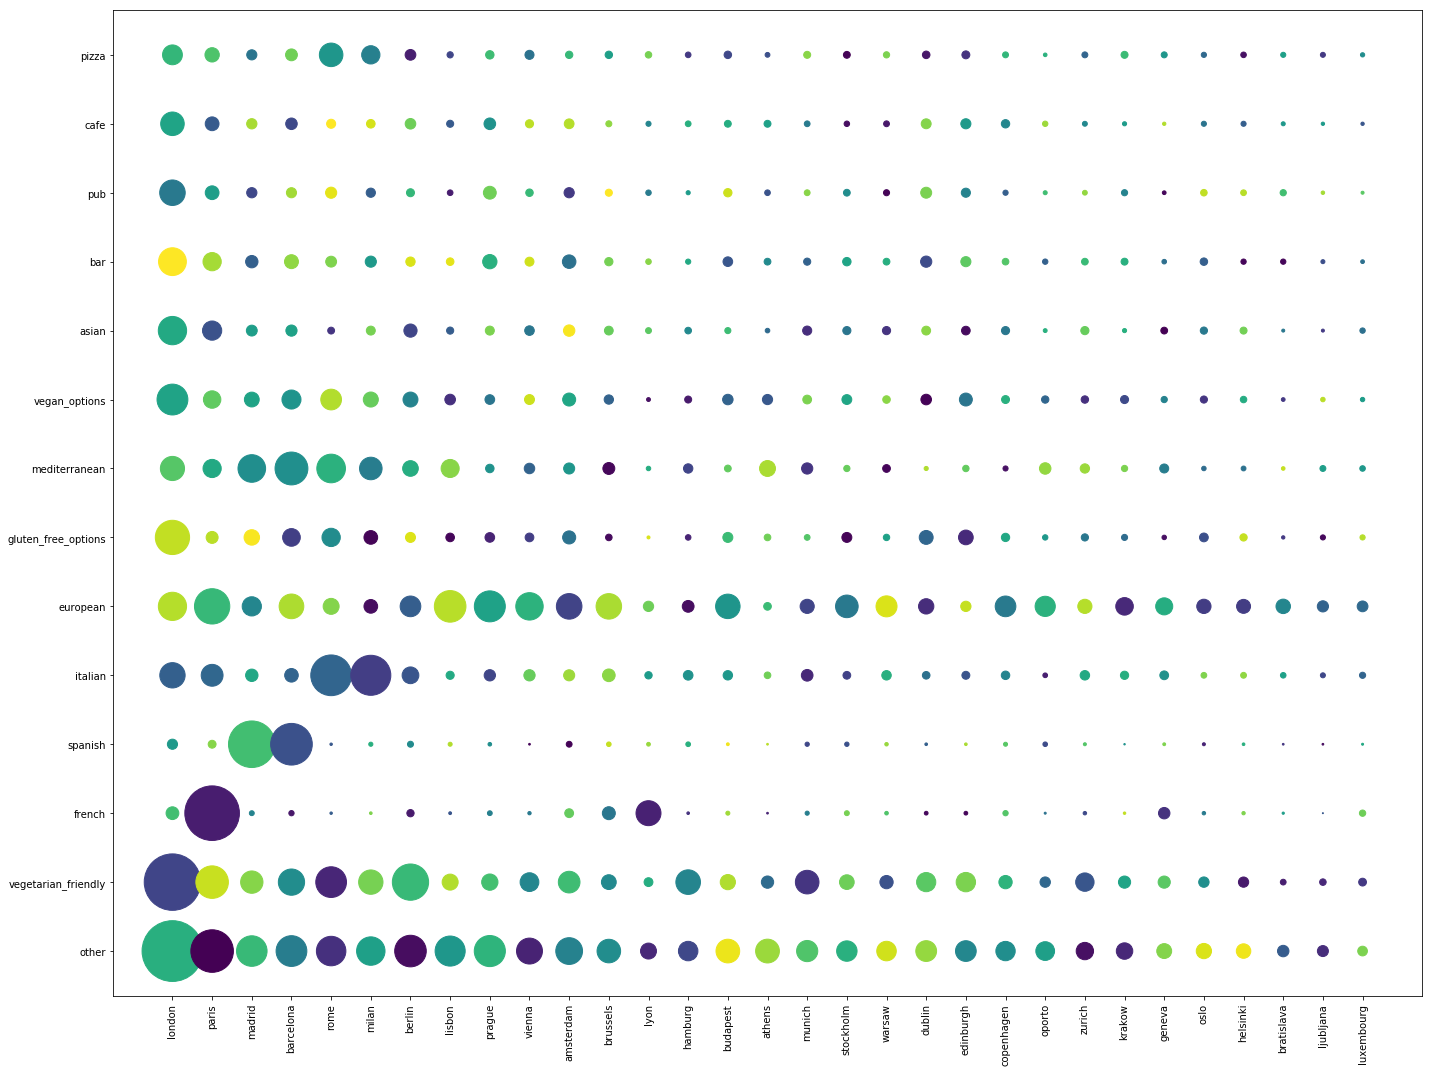

In [15]:
# посмотрим на распределение кухонь в каждом городе после замены пропусков и выбора только 90% выборки
df_city_cuisine = data[data.is_train][['city', 'cuisine_style_top_n']].explode('cuisine_style_top_n')
# display(df_city_cuisine['cuisine_style_top_n'].value_counts())
scatter_for_two_columns_with_count(df_city_cuisine, 'city', 'cuisine_style_top_n', figsize=(20, 15))

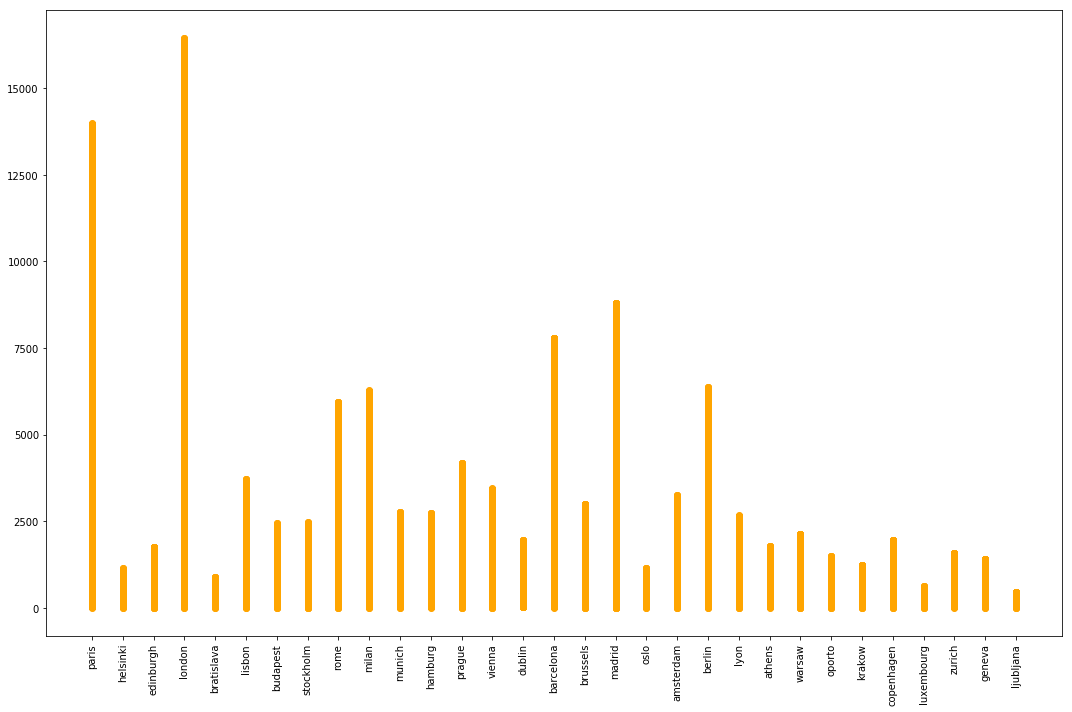

In [16]:
# 4) ranking - [nan: no]
# ranking — место, которое занимает данный ресторан среди всех ресторанов своего города

# посмотрим на распределение мест в каждом городе 
plt.figure(figsize=(15,10))
plt.xticks(rotation='vertical')
plt.scatter(data[data.is_train]['city'], data[data.is_train]['ranking'], c='orange');
plt.tight_layout()
# data[data.is_train]['ranking'].hist(figsize=(10,5), bins=50, color=['orange'], log = False);
# data[data.is_train]['city'].value_counts(ascending=True).plot(kind='barh', figsize=(10,6), color=['orange']);
# scatter_for_two_columns_with_count(data[data.is_train], 'ranking', 'city', figsize=(20, 15))

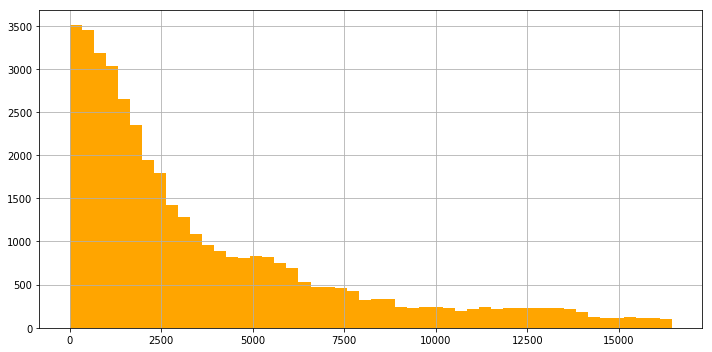

In [17]:
data[data.is_train]['ranking'].hist(figsize=(10,5), bins=50, color=['orange'], log = False);
plt.tight_layout()
# выбросов нет, многие рестораны, не дотягивают и до 2500 места в своем городе

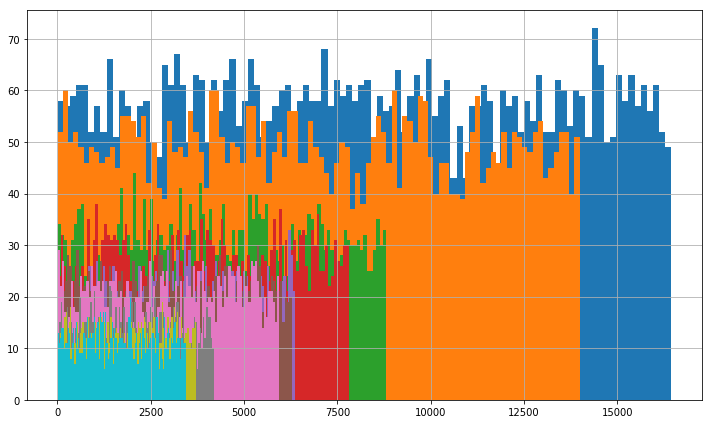

In [18]:
# посмотрим на топ 10 городов
for city in (data[data.is_train]['city'].value_counts())[0:10].index:
    data[data.is_train & (data['city'] == city)]['ranking'].hist(bins=100, figsize=(10,6))
plt.tight_layout()

In [19]:
# получается, что ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.
restorants_in_city = data.groupby('city')['ranking'].count().to_dict()
# display(restorants_in_city)

# вычисляем  общее количество ресторанов в городе
data['number_restaurants_city'] = data['city'].map(restorants_in_city)
# display(data.sample(5))

In [20]:
# нормализуем или MinMax рейтинг ресторанов относительно города

# scaler = MinMaxScaler()
# scaler.fit_transform(test_data)

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler.fit_transform(test_data)

for city in set(data[data.is_train]['city'].value_counts().index):
    # производим замену нормализованными данными основной датасет с учетом train и test
      
    # train
    train = data[data.is_train & (data['city'] == city)]
    ranking_array_train = train['ranking'].values.reshape(-1, 1)  
    ranking_array_train_transformed = scaler.fit_transform(ranking_array_train)
    
    ranking_array_train_one_dimension = np.reshape(ranking_array_train_transformed, (1,np.product(ranking_array_train_transformed.shape)))[0]
    # display(ranking_array_one_dimension)  
    data.loc[data.is_train & (data['city'] == city), 'ranking_standard'] = ranking_array_train_one_dimension 
  
    # test
    test = data[~data.is_train & (data['city'] == city)]
    ranking_array_test = test['ranking'].values.reshape(-1, 1)  
    ranking_array_test_transformed = scaler.transform(ranking_array_test)
    
    ranking_array_test_one_dimension = np.reshape(ranking_array_test_transformed, (1,np.product(ranking_array_test_transformed.shape)))[0]

    data.loc[~data.is_train & (data['city'] == city), 'ranking_standard'] = ranking_array_test_one_dimension

display(data.sample(5))

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,cuisine_style_top_n,number_restaurants_city,ranking_standard
43911,2212,lyon,[french],2213.0,NaN,8.0,"[['A lively and busy restaurant.', 'Great Pita, Poor ?Kebab?'], ['07/31/2017', '05/03/2017']]",/Restaurant_Review-g187265-d5890561-Reviews-Le_Galata-Lyon_Rhone_Auvergne_Rhone_Alpes.html,d5890561,True,3.5,-6974863120733901198,france,0,0.5,47.87,10041,174,12.0,1015,53758.0,1,1,[french],1126,0.830019
38750,8332,madrid,[contemporary],8339.0,NaN,38.0,"[['Decent food but slow service...', ""Just don't""], ['02/26/2017', '02/27/2017']]",/Restaurant_Review-g187514-d6654290-Reviews-Trinkhalle-Madrid.html,d6654290,True,2.5,992849973989854412,spain,1,3.2,604.30,5380,667,14.5,415,50434.0,1,1,[other],3813,0.946639
33287,6817,barcelona,[spanish],6818.0,NaN,10.0,"[[""Amazing iced latte, but it'll cost ya"", 'WOW what a Expresso CoffeLovers'], ['07/28/2017', '01/10/2018']]",/Restaurant_Review-g187497-d12009782-Reviews-Nomad_Every_Day-Barcelona_Catalonia.html,d12009782,True,3.5,5374732627027560976,spain,0,1.6,101.90,15779,12,15.5,614,43790.0,1,1,[spanish],3395,0.874471
49583,95,geneva,"[japanese, sushi, asian, vegetarian friendly, gluten free options]",96.0,$$$$,158.0,"[['For me: best sushis in town...', 'A nice discovery, but authentic Japanese?'], ['11/13/2017', '10/21/2017']]",/Restaurant_Review-g188057-d784997-Reviews-Kakinuma-Geneva.html,d784997,True,4.5,751517347588220765,switzerland,0,0.2,15.93,12589,375,10.0,1468,59394.0,0,5,"[asian, gluten_free_options, other, vegetarian_friendly]",590,0.064631
29875,548,dublin,"[european, wine bar, vegetarian friendly]",549.0,$$ - $$$,29.0,"[['Regular Customer Visit', 'What kept me'], ['11/08/2017', '10/14/2017']]",/Restaurant_Review-g186605-d8521635-Reviews-Green_Man_Wines-Dublin_County_Dublin.html,d8521635,True,4.5,7731243350169499267,ireland,1,1.1,318.00,3689,12,9.4,919,100479.0,1,3,"[european, other, vegetarian_friendly]",836,0.277152


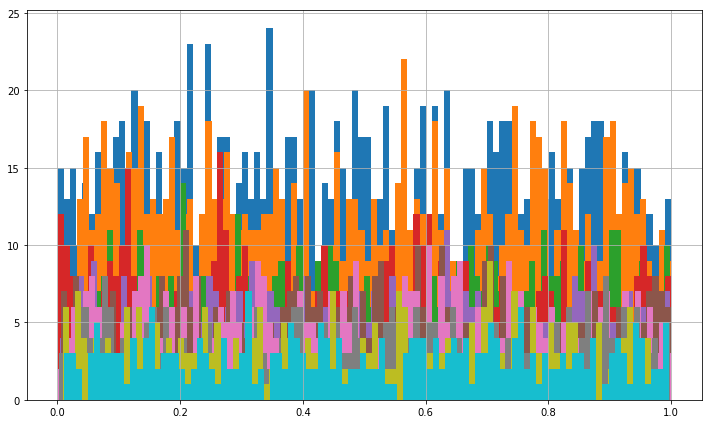

In [21]:
# снова смотрим на топ 10 городов
for city in (data[data.is_train]['city'].value_counts())[0:10].index:
    data[~data.is_train & (data['city'] == city)]['ranking_standard'].hist(bins=100, figsize=(10,6))
plt.tight_layout()

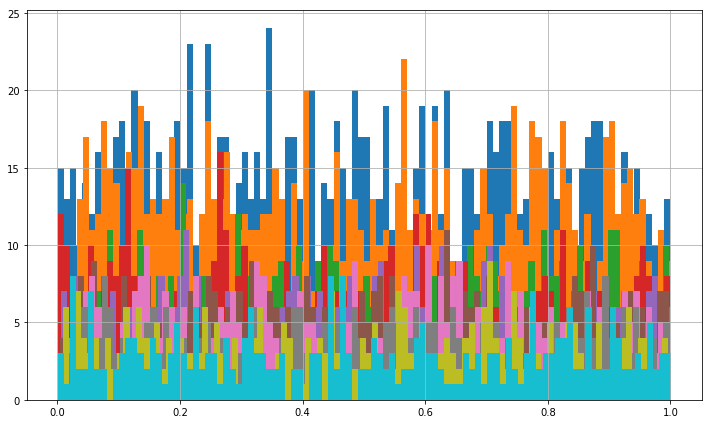

In [22]:
# также посмотрим правильно нормализовалась тестовая выбока, смотрим на топ 10 городов
for city in (data[~data.is_train]['city'].value_counts())[0:10].index:
    data[~data.is_train & (data['city'] == city)]['ranking_standard'].hist(bins=100, figsize=(10,6))
plt.tight_layout()

In [23]:
# 5) price_range - [nan: yes]

display(data[data.is_train]['price_range'].value_counts(dropna=False))
dict_nums = {'price_range': {"$": 1, "$$ - $$$": 2, "$$$$": 3}}
data.replace(dict_nums, inplace=True)

# посмотрим на распределение цены в каждом городе 
# scatter_for_two_columns_with_count(data[data.is_train], 'price_range', 'city', figsize=(20, 15))
display(data['price_range'].value_counts(dropna=False))

# посмотрим влияет ли город на цену и получим самое часто встречаемое значение
for city in set(data['city'].value_counts().index): 
    # самая популярный диапазон цен в городе
    freq_price_range = data[data.is_train & (data['city'] == city)]['price_range'].mode(dropna=True)[0]
    print(city, freq_price_range)
#     data.loc[(data['city'] == city) & (pd.isna(data['price_range'])), 'price_range'] = [freq_cuisine_of_city]

# независимо от города самое частое значение это 2, заменим им пропуски
data['price_range'].fillna(2, inplace=True)
# display(data.sample(5))
display(data.info())

$$ - $$$    18412
NaN         13886
$           6279 
$$$$        1423 
Name: price_range, dtype: int64

2.0    23041
NaN    17361
1.0    7816 
3.0    1782 
Name: price_range, dtype: int64

brussels 2.0
prague 2.0
dublin 2.0
barcelona 2.0
lisbon 2.0
luxembourg 2.0
edinburgh 2.0
london 2.0
stockholm 2.0
milan 2.0
vienna 2.0
copenhagen 2.0
budapest 2.0
rome 2.0
paris 2.0
athens 2.0
munich 2.0
madrid 2.0
krakow 2.0
warsaw 2.0
ljubljana 2.0
geneva 2.0
bratislava 2.0
oporto 2.0
amsterdam 2.0
helsinki 2.0
lyon 2.0
berlin 2.0
hamburg 2.0
zurich 2.0
oslo 2.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 26 columns):
restaurant_id                             50000 non-null int64
city                                      50000 non-null object
cuisine_style                             50000 non-null object
ranking                                   50000 non-null float64
price_range                               50000 non-null float64
number_of_reviews                         46800 non-null float64
reviews                                   49998 non-null object
url_ta                                    50000 non-null object
id_ta     

None

0    46800
1    3200 
Name: number_of_reviews_nan, dtype: int64

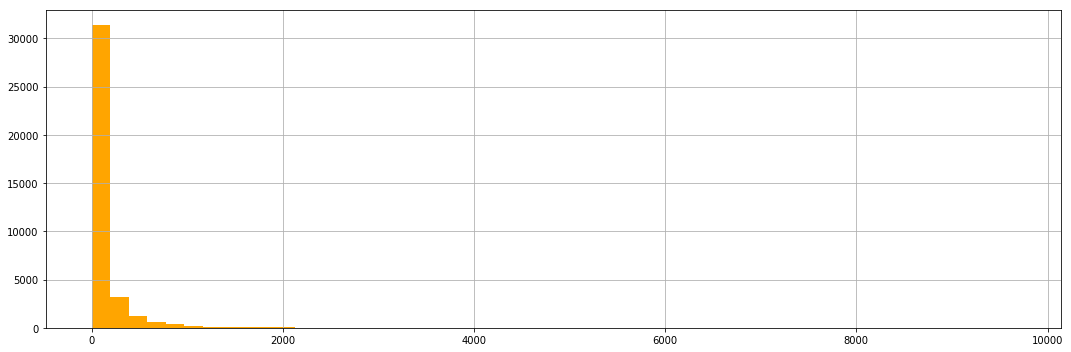

In [24]:
# 6) number_of_reviews - [nan: yes]
# создаем признак с информацией о наличии пропуска
data['number_of_reviews_nan'] = pd.isna(data['number_of_reviews']).astype('uint8') 
display(data['number_of_reviews_nan'].value_counts())

# посмотрим на распределение цены в каждом городе 
data[data.is_train]['number_of_reviews'].hist(figsize=(15,5), bins=50, color=['orange'], log = False); # прологарифмируем, чтобы лучше было видно выбросы
plt.tight_layout()
# scatter_for_two_columns_with_count(data[data.is_train], 'city' , 'number_of_reviews', figsize=(20, 15))

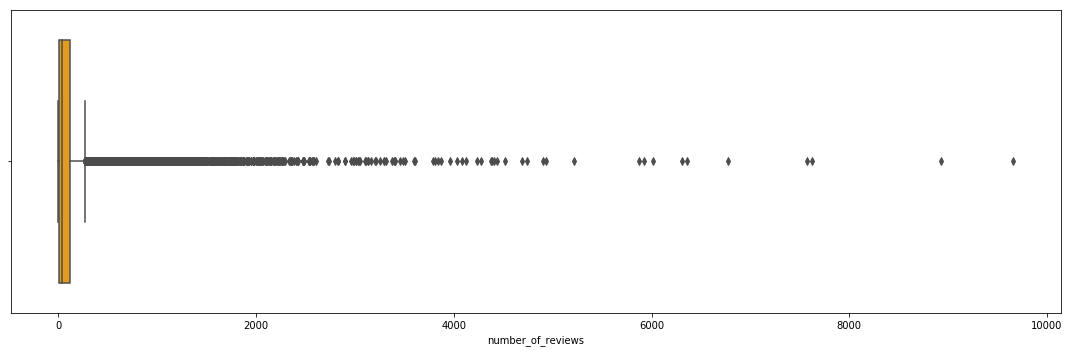

In [25]:
plt.figure(figsize=(15,5))
sns.boxplot(data[data.is_train ]['number_of_reviews'], color='orange');
plt.tight_layout()

Cреднее значение до удаления выбросов: 124.47119658119658
Среднее для значений меньше определенного порога: 113.28377798747533
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 27 columns):
restaurant_id                             50000 non-null int64
city                                      50000 non-null object
cuisine_style                             50000 non-null object
ranking                                   50000 non-null float64
price_range                               50000 non-null float64
number_of_reviews                         50000 non-null float64
reviews                                   49998 non-null object
url_ta                                    50000 non-null object
id_ta                                     50000 non-null object
is_train                                  50000 non-null bool
rating                                    50000 non-null float64
city_hash                                 50000 non-null in

None

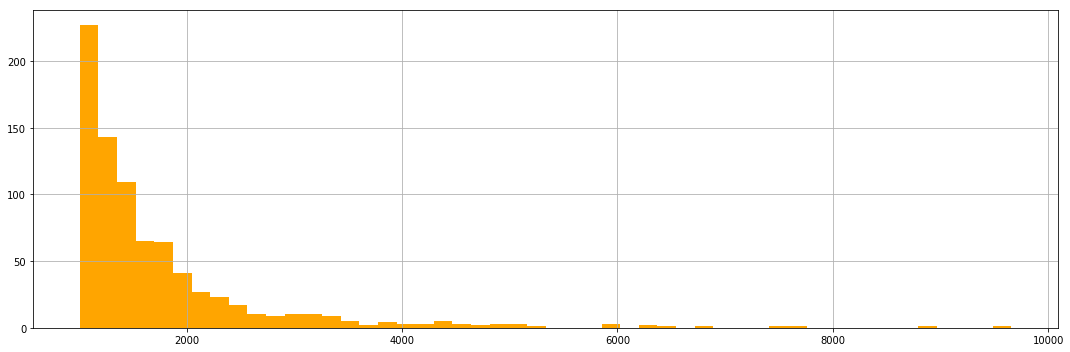

In [26]:
# скорее всего в количестве отзывов есть выбросы

# почистим выбросы и заменим пустые значения на средее
# display(np.sum(data['number_of_reviews'] == 0)) # нулевых значений нет
# max 9660.0
# display(data['number_of_reviews'].value_counts(dropna=True, normalize=True))

print('Cреднее значение до удаления выбросов:', data['number_of_reviews'].mean(skipna=True))
print('Среднее для значений меньше определенного порога:', data[data['number_of_reviews'] < 2000]['number_of_reviews'].mean(skipna=True))

# plt.figure(figsize=(10,5));
# # plt.xticks(rotation='vertical')
# plt.hist(outliers, density=False, bins=100, color=['orange']);  # density=False would make counts
# plt.title('Outliers');
# plt.ylabel('Count');
# plt.xlabel('Number of reviews');
# # plt.xticks(rotation='vertical')
# # plt.tight_layout()

# поиск по отклонению (z-score)
outliers = outliers_z_score_index(data[data['number_of_reviews'].notna()]['number_of_reviews'])

# выбросы есть и в тестововой выборке
# data_is_test = data[~data.is_train]
data.iloc[data.index.isin(outliers)]['number_of_reviews'].hist(figsize=(15,5), bins=50, color=['orange'], log = False);
plt.tight_layout()
# вывод: выбросы вроде есть, но удалять их или нет я пока не могу. 
# тем более может уменьшится тестовая выборка. Поэтому пока заполним пустые значения - средним

number_of_reviews_mean = round(data[data.is_train]['number_of_reviews'].mean(skipna=True))
data['number_of_reviews'].fillna(number_of_reviews_mean, inplace=True)
display(data.info())
# show_dataset_info()

In [27]:
# 7) reviews - [nan: yes] - 2 последних отзыва и даты этих отзывов
# cодержит всего два пропуска

# замениим '[[], []]' на NAN
data.loc[data['reviews'] == '[[], []]', 'reviews'] = np.nan

# cоздадим новый признак, reviews_nan показываюющий что отзывов нет у данного ресторана
data['reviews_nan'] = pd.isna(data['reviews']).astype('uint8')

# display(data['reviews'].value_counts(dropna=False))

# парсим отзывы
review_converted_list = data['reviews'].map(reviews_column_convert)
# display(review_converted_list)


review_converted_list_without_nan = review_converted_list[~pd.isna(review_converted_list)]
display(review_converted_list_without_nan[1010:])

data['review_1_text'] = review_converted_list_without_nan.apply(lambda x: x[0])
data['review_1_date'] = pd.to_datetime(review_converted_list_without_nan.apply(lambda x: x[2]))

data['review_2_text'] = review_converted_list_without_nan.apply(lambda x: x[1])
data['review_2_date'] = pd.to_datetime(review_converted_list_without_nan.apply(lambda x: x[3]))

# data['reviews_list_len'] = review_converted_list_without_nan.apply(lambda x: x[4])
# show_dataset_info()

1253     [Perfect for a simple lunch, Delicious, 07/19/2017, 01/04/2018]                              
1254     [Great Neighborhood Family Restaurant, Great Bistro and food, 10/23/2017, 10/17/2017]        
1255     [A gem in St. Germaine, Friendly, small neighborhood restaurant, 09/23/2017, 05/31/2017]     
1256     ["Don't eat in this racist place", 'Au Clair de Lune forever, nan, 11/03/2017, nan]          
1258     [A small place with reasonable food, Fresh and Tasty Jap food, 06/13/2017, 12/16/2017]       
                                                  ...                                                 
49995    [Nice place, Quiz, 03/31/2017, 01/25/2017]                                                   
49996    [By the river, Unique experience!, 08/18/2017, 06/07/2017]                                   
49997    ["It's always nice to be here.", 'Food is good, but staff...., nan, 02/06/2017, nan]         
49998    [Good and fast food, The best kebab in town, 12/17/2017, 05/22/2

In [28]:
# продолжаем создавать новые признаки на основе анализа признака 'reviews'

# 1) Вычислим максимальную дата среди всех отзывов и вычтем из нее все даты отзывов.
#    Текущую дату брать нельзя, тк не понятно когда был сделан срез данных
# 2) Найдем среднее число дней прошедшее между отзывами
# 3) Назовем новый признак reviews_means_days

review_max_date = max(data['review_1_date'].max(),data['review_2_date'].max())
# display(review_max_date)

review_1_days_count_between_max_date = (review_max_date - data['review_1_date']).dt.components['days']
# display(review_1_days_count)

review_2_days_count_between_max_date = (review_max_date - data['review_2_date']).dt.components['days']
# display(review_2_days_count)

# Вычисляем число дней между отзывами и берем абсолютное значение, тк даты отзывов не отсортированы
review_days_count_between_reviews = abs((data['review_1_date'] - data['review_2_date']).dt.components['days'])

# display(ss1.value_counts(dropna=False))
# display(ss1[ss1 < 0].value_counts(dropna=False))
# ss1.value_counts(dropna=False).hist()


# data['review_1_days_count_between_max_date'] = review_1_days_count_between_max_date
# data['review_2_days_count_between_max_date'] = review_2_days_count_between_max_date
# data['review_days_count_between_reviews'] = review_days_count_between_reviews
#data['review_days_means_between_reviews'] = (review_1_days_count_between_max_date + review_2_days_count_between_max_date +review_days_count_between_reviews)/3
data['review_min_days_review'] = pd.concat([review_1_days_count_between_max_date, review_2_days_count_between_max_date], axis=1).min(axis=1)

# среднее число дней прошедшее с момента последнего отзыва
mean_days = round(data['review_min_days_review'].mean())
display(mean_days)

# заполняем пропуски
data['review_min_days_review'].fillna(mean_days, inplace=True)

# считаем отзыв новым если его оставили не позже 90 дней
data['review_has_new_review'] = data['review_min_days_review'].apply(lambda x: (1 if x < 90 else 0) if ~pd.isna(x) else x)
display(data['review_has_new_review'].value_counts(dropna=False))

# fill_value = -1
# data['review_1_days_count_between_max_date'].fillna(fill_value, inplace=True)
# data['review_2_days_count_between_max_date'].fillna(fill_value, inplace=True)
# data['review_days_count_between_reviews'].fillna(fill_value, inplace=True)
# data['review_days_means_between_reviews'].fillna(fill_value, inplace=True)
# data['review_has_new_review'].fillna(fill_value, inplace=True)

show_dataset_info()
# Удаляем признаки содержащие даты отзывов
# data.drop(['review_1_date', 'review_2_date'], axis=1, inplace=True)

290

0    37728
1    12272
Name: review_has_new_review, dtype: int64

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,cuisine_style_top_n,number_restaurants_city,ranking_standard,number_of_reviews_nan,reviews_nan,review_1_text,review_1_date,review_2_text,review_2_date,review_min_days_review,review_has_new_review
26440,6043,prague,[cafe],750.0,2.0,40.0,"[['atmosphere that is truly unique', 'Great view at night'], ['08/30/2017', '02/05/2017']]",/Restaurant_Review-g274707-d7124071-Reviews-Kavarna_Na_Krizovnickem_Namesti-Prague_Bohemia.html,d7124071,False,0.0,-7372162860925639421,czech republic,1,1.3,496.00,2506,191,9.8,687,59455.0,1,1,[cafe],1816,0.178691,0,0,atmosphere that is truly unique,2017-08-30,Great view at night,2017-02-05,180.0,0
11421,8447,london,"[spanish, cuban, vegetarian friendly]",8456.0,2.0,52.0,"[['Good but not great', 'Delicious food, friendly staff'], ['09/14/2017', '09/06/2017']]",/Restaurant_Review-g186338-d4835329-Reviews-El_Botellon-London_England.html,d4835329,True,4.0,6142954055757551913,united kingdom,1,8.9,1572.00,5667,11,10.8,690,68496.0,1,3,"[spanish, other, vegetarian_friendly]",7193,0.514201,0,0,Good but not great,2017-09-14,"Delicious food, friendly staff",2017-09-06,165.0,0
32733,3443,barcelona,"[steakhouse, latin, barbecue, argentinean]",3444.0,2.0,172.0,"[['Sublime steak. Substandard Service', 'First time and last.'], ['01/29/2017', '12/07/2017']]",/Restaurant_Review-g187497-d997221-Reviews-Argento-Barcelona_Catalonia.html,d997221,True,3.5,5374732627027560976,spain,0,1.6,101.90,15779,12,15.5,614,43790.0,1,4,[other],3395,0.441407,0,0,Sublime steak. Substandard Service,2017-01-29,First time and last.,2017-12-07,81.0,1
29517,2194,dublin,"[asian, chinese]",1857.0,1.0,17.0,"[['Weak', 'Poor vegetarian version, no WiFi'], ['10/03/2016', '02/16/2016']]",/Restaurant_Review-g186605-d4413739-Reviews-Wokin_Noodle_and_Rice_Bar-Dublin_County_Dublin.html,d4413739,False,0.0,7731243350169499267,ireland,1,1.1,318.00,3689,12,9.4,919,100479.0,1,2,"[asian, other]",836,0.947234,0,0,Weak,2016-10-03,"Poor vegetarian version, no WiFi",2016-02-16,511.0,0
34801,2532,brussels,"[belgian, european, french]",2533.0,2.0,77.0,"[['Pretty average', 'Warm welcome, great food'], ['12/05/2017', '04/12/2017']]",/Restaurant_Review-g188644-d966729-Reviews-L_Atelier_Europeen-Brussels.html,d966729,True,3.5,-6267173527456332927,belgium,1,0.2,32.61,5497,13,10.7,807,74574.0,1,3,"[european, other, french]",1314,0.843052,0,0,Pretty average,2017-12-05,"Warm welcome, great food",2017-04-12,83.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 34 columns):
restaurant_id                             50000 non-null int64
city                                      50000 non-null object
cuisine_style                             50000 non-null object
ranking                                   50000 non-null float64
price_range                               50000 non-null float64
number_of_reviews                         50000 non-null float64
reviews                                   41886 non-null object
url_ta                                    50000 non-null object
id_ta                                     50000 non-null object
is_train                                  50000 non-null bool
rating                                    50000 non-null float64
city_hash                                 50000 non-null int64
страна                                    50000 non-null object
столица                                   50000 non-null in

None

### Определяем тональность отзывов и создаем новый признак на основании статьи https://www.youtube.com/watch?v=NPJ1kF-63VI

In [29]:
# создадим признак reviews_is_positive - показывает в среднем были ли отзывы положительными - 1 или отрицательными - 0
df_reviews_with_sentiment.rename(columns = {'review_2_sentiment_mean' : 'reviews_is_positive'}, inplace = True)
# display(df_reviews_with_sentiment.sample(5))

# объединяем датасеты
data = pd.concat([data, df_reviews_with_sentiment['reviews_is_positive']],  axis=1, sort=False)
# x = pd.concat([data, df_reviews_with_sentiment],  axis=1, sort=False)
# x.sample(10)

display(data['reviews_is_positive'].value_counts(dropna=False))

# заполним пропуски
data['reviews_is_positive'].fillna(0, inplace = True)

# data.drop(['Unnamed: 0', 'index', 'review_1_text_sentiment', ''], axis=1, inplace=True)
# display(data[['review_1_text','review_2_text']])
# data[['review_1_text','review_2_text']] .to_csv('reviews_to_determine_sentiment.csv')
data.sample(5)

1.0    34590
NaN    8114 
0.0    7296 
Name: reviews_is_positive, dtype: int64

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,cuisine_style_top_n,number_restaurants_city,ranking_standard,number_of_reviews_nan,reviews_nan,review_1_text,review_1_date,review_2_text,review_2_date,review_min_days_review,review_has_new_review,reviews_is_positive
7685,2464,london,"[bar, british, pub, vegetarian friendly]",8840.0,2.0,122.0,"[['Nice atmosphere and excellent service', 'Quiet mid week night'], ['11/22/2017', '11/08/2017']]",/Restaurant_Review-g186338-d733327-Reviews-The_Castle-London_England.html,d733327,False,0.0,6142954055757551913,united kingdom,1,8.9,1572.00,5667,11,10.8,690,68496.0,1,4,"[pub, vegetarian_friendly, other, bar]",7193,0.537554,0,0,Nice atmosphere and excellent service,2017-11-22,Quiet mid week night,2017-11-08,96.0,0,1.0
44635,7426,athens,[greek],664.0,2.0,31.0,"[['Nice view', 'Excellent drinks with a view'], ['03/25/2017', '03/11/2017']]",/Restaurant_Review-g189400-d8144281-Reviews-Gazi_View-Athens_Attica.html,d8144281,False,0.0,-138796707456638393,greece,1,3.0,412.00,7500,71,17.5,378,59394.0,1,1,[other],776,0.369455,0,0,Nice view,2017-03-25,Excellent drinks with a view,2017-03-11,338.0,0,1.0
48577,5127,zurich,"[indian, swiss, european, asian, vegetarian friendly, vegan options]",1510.0,2.0,10.0,"[['Spending time with family'], ['06/07/2015']]",/Restaurant_Review-g188113-d8064348-Reviews-Hiltl_am_Strand_Strandbad_Mythenquai-Zurich.html,d8064348,False,0.0,1802726038371401080,switzerland,0,0.4,87.88,4666,408,9.7,1463,76596.0,0,6,"[european, other, vegetarian_friendly, vegan_options, asian]",685,0.949622,0,0,Spending time with family,2015-06-07,NaN,NaT,995.0,0,1.0
384,3259,paris,[american],11921.0,2.0,2.0,"[['Good quality and good price'], ['01/24/2015']]",/Restaurant_Review-g187147-d4567324-Reviews-United_Friends_Chicha-Paris_Ile_de_France.html,d4567324,False,0.0,-4465655500759980104,france,1,2.1,105.40,20781,35,11.7,720,66148.0,1,1,[other],6108,0.852321,0,0,Good quality and good price,2015-01-24,NaN,NaT,1129.0,0,1.0
2203,3752,paris,[french],3753.0,2.0,152.0,"[['Good service', 'Good for lunch'], ['06/20/2017', '03/07/2017']]",/Restaurant_Review-g187147-d4758948-Reviews-L_Etincelle-Paris_Ile_de_France.html,d4758948,True,4.0,-4465655500759980104,france,1,2.1,105.40,20781,35,11.7,720,66148.0,1,1,[french],6108,0.268183,0,0,Good service,2017-06-20,Good for lunch,2017-03-07,251.0,0,1.0


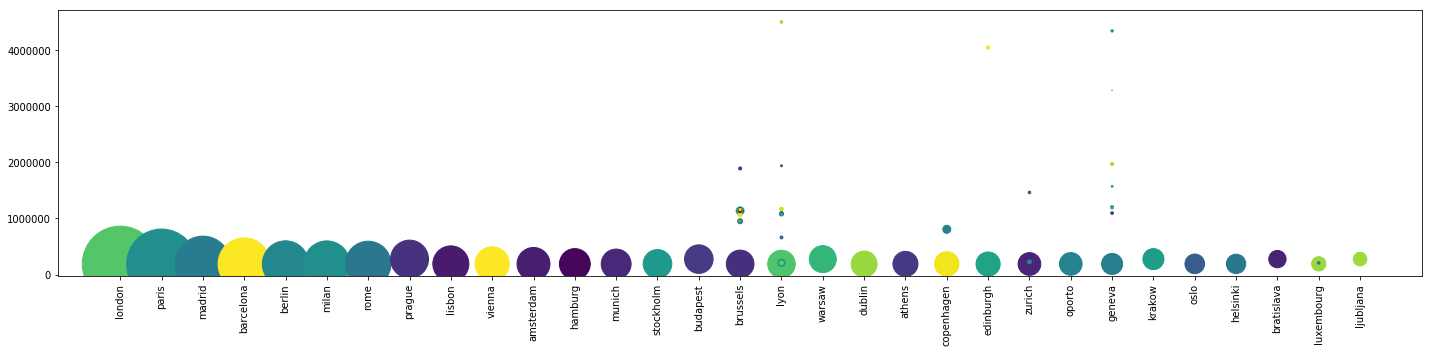

In [30]:
# 8) url_ta - URL страницы ресторана на TripAdvisor [nan: no]
# номер вида g189852 - это возможно идентификатор района города

district_of_city = data['url_ta'].apply(lambda x: x.split('-', maxsplit=2)[1].strip("g"))
data['district_of_city_id'] = district_of_city.astype('int')
# display(data['district_of_city_id'])

# data['district_of_city_id'] = data['url_ta'].apply(lambda x: x.split('-', maxsplit=2)[1])
# display(data['district_of_city_id'])

# display(data['district_of_city_id'].value_counts(dropna=False))

# data[data.is_train]['district_of_city_id'].hist(figsize=(15,5), bins=50, color=['orange'], log = True);
scatter_for_two_columns_with_count(data[data.is_train], 'city', 'district_of_city_id', figsize=(20, 5));

# создадим признак показывающий число рестранов к каждом районе города
district_of_city = data.groupby(['city','district_of_city_id'])['district_of_city_id'].count().to_dict()

# display(('brussels') in district_of_city)
# display(district_of_city)
data['number_restaurants_in_district_of_city'] = data[['city','district_of_city_id']].apply(lambda x: district_of_city[(x[0],x[1])] if (x[0],x[1]) in district_of_city else np.nan, axis=1)

# display(data[(data['city'] == 'zurich')]['number_restaurants_in_district_of_city'].value_counts(dropna=False))

In [31]:
# cоздаем новый признак который показывает номер района города
city_grouped = data.groupby(['city']).groups
# display(grouped_df['district_of_city_id'].groups)

for city_group in city_grouped:
    data_by_city = data.loc[city_grouped[city_group]]['district_of_city_id']
    district_list = list(set(data_by_city))
    # print(city_group, district_list, len(district_list))

    data.loc[city_grouped[city_group],'district_number'] = data_by_city.apply(lambda x: district_list.index(x)+1)

data['district_number'] = data['district_number'].astype('uint')

# получилось что некоторые города имеют до 19 районов
# display(data['district_number'].value_counts(dropna=False))

# удаляем district_of_city_id
data.drop(['district_of_city_id'], axis=1, inplace=True)

data.sample(5)
# data.info()
# show_dataset_info()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,площадь_км2,плотность_населения_чел/км2,высота_нум_метров,среднегодовая_температура_цельсий,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,cuisine_style_top_n,number_restaurants_city,ranking_standard,number_of_reviews_nan,reviews_nan,review_1_text,review_1_date,review_2_text,review_2_date,review_min_days_review,review_has_new_review,reviews_is_positive,number_restaurants_in_district_of_city,district_number
25214,7623,hamburg,[vegetarian friendly],1733.0,2.0,27.0,"[['great place to watch soccer!!!!!'], ['08/11/2016']]",/Restaurant_Review-g187331-d1038916-Reviews-Cafe_Strauss-Hamburg.html,d1038916,False,0.0,4347543484403387382,germany,0,1.8,755.2,2424,5,9.8,804,60741.0,1,1,[vegetarian_friendly],1186,0.633272,0,0,great place to watch soccer!!!!!,2016-08-11,NaN,NaT,564.0,0,0.0,1186,1
26992,1102,prague,[european],1103.0,2.0,14.0,"[['Additions to menu', ""I'll be back...gluten free.""], ['12/31/2016', '11/02/2016']]",/Restaurant_Review-g274707-d10537317-Reviews-Moje_Cukrarstvi-Prague_Bohemia.html,d10537317,True,4.5,-7372162860925639421,czech republic,1,1.3,496.0,2506,191,9.8,687,59455.0,1,1,[european],1816,0.263020,0,0,"Additions to menu', ""I'll be back...gluten free.""",2016-12-31,NaN,NaT,422.0,0,1.0,1816,1
32961,4507,barcelona,[spanish],4508.0,2.0,18.0,"[['Good place to grab something', 'Service and Food A+'], ['08/06/2017', '09/15/2016']]",/Restaurant_Review-g187497-d10041251-Reviews-Lizarran-Barcelona_Catalonia.html,d10041251,True,4.0,5374732627027560976,spain,0,1.6,101.9,15779,12,15.5,614,43790.0,1,1,[spanish],3395,0.577975,0,0,Good place to grab something,2017-08-06,Service and Food A+,2016-09-15,204.0,0,1.0,3395,1
45694,273,warsaw,[american],274.0,2.0,49.0,"[['Surprisingly good', 'Very good meat'], ['08/02/2017', '02/09/2017']]",/Restaurant_Review-g274856-d3844279-Reviews-American_House_Baletowa_Restauracja-Warsaw_Mazovia_Province_Central_Poland.html,d3844279,True,4.5,3718709216435712467,poland,1,1.7,517.2,3461,100,9.3,695,64335.0,1,1,[other],925,0.127570,0,0,Surprisingly good,2017-08-02,Very good meat,2017-02-09,208.0,0,0.0,925,1
42588,3459,berlin,[vegetarian friendly],3461.0,2.0,2.0,NaN,/Restaurant_Review-g187323-d11645802-Reviews-Cafe_B-Berlin.html,d11645802,True,5.0,-7331892757916969100,germany,1,3.6,891.8,4463,34,10.1,669,45311.0,1,1,[vegetarian_friendly],2705,0.543014,0,1,NaN,NaT,NaN,NaT,290.0,0,1.0,2705,1


10316215    2
1028622     2
697406      2
8753348     2
7337366     2
           ..
719498      1
7660169     1
4418110     1
12431266    1
720896      1
Name: id_ta, Length: 49963, dtype: int64

0    9522
1    8132
2    7516
3    7043
5    6308
6    5742
4    5737
Name: id_ta_group, dtype: int64

Series([], Name: id_ta, dtype: int64)

Series([], Name: id_ta, dtype: int64)

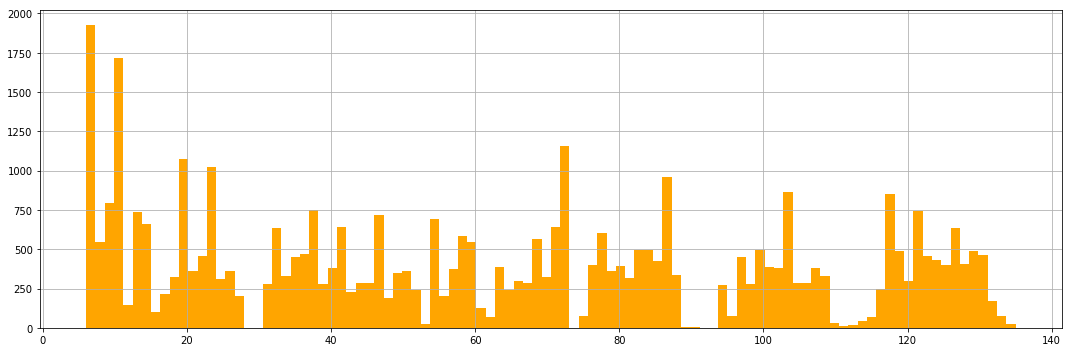

In [32]:
# 9) id_ta — [nan: yes] идентификатор ресторана в базе данных TripAdvisor
data['id_ta'] = data['id_ta'].apply(lambda x: x.replace('d','')).astype(int)
display(data['id_ta'].value_counts(dropna=True))

((data[data.is_train]['id_ta'] // 100000)).hist(figsize=(15,5), bins=100, color=['orange'], log = False);
plt.tight_layout()
# видно несколько подозрительных групп! Пока не понятно в чем их суть

# найдем порядок числа с помощью np.log10
# data['id_ta_group'] = data['id_ta'].apply(lambda x: int(np.log10(x)))
data['id_ta_group'] = data['id_ta'].apply(lambda x: x // 2000000)
display(data['id_ta_group'].value_counts(dropna=False))

# есть небольшое количество дубликатов по признаку 'id_ta'
# ПОЗЖЕ! пока не ясно повлияет ли столь малое число дубликатов на итоговый результат

# в тесте нет дубликатов но и удалять из тест нельзя, тк тогда не совпадет число строк при получении submission
sample_test_dublicate = data[~data.is_train]['id_ta'].value_counts()
display(sample_test_dublicate[sample_test_dublicate > 1])

# в трейне есть дубликаты 
sample_train_dublicate =  data[~data.is_train]['id_ta'].value_counts()
display(sample_train_dublicate[sample_train_dublicate > 1])

# удалим дубликаты (позже удалим)
# data.drop_duplicates(subset=['id_ta'], inplace=True)

# удаляем district_of_city_id
# data.drop(['id_ta'], axis=1, inplace=True)
# data.info()

# pd.qcut(data[data.is_train]['id_ta'], q=4, precision=0).value_counts()


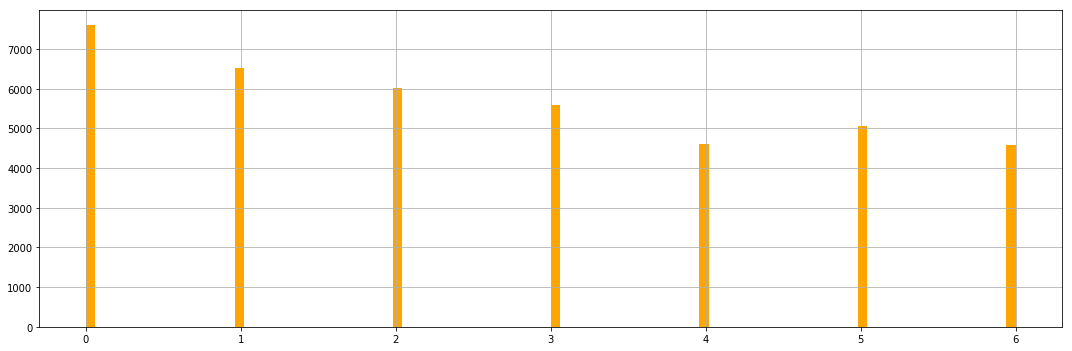

In [33]:
((data[data.is_train]['id_ta'] // 100000) // 20).hist(figsize=(15,5), bins=100, color=['orange'], log = False);
plt.tight_layout()

# EDA 

## Feature engineering

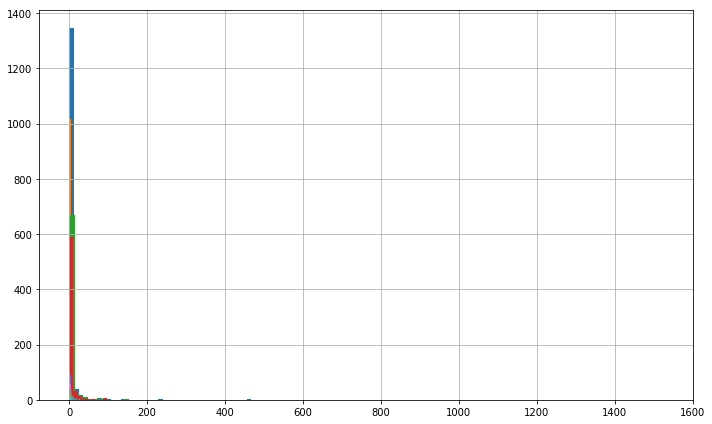

In [34]:
# вычисляем долю которую занимает ресторан в городе относительно своего места
# немного дублирую признак ranking_standard
data['rank_weighed'] = data['ranking'] / data['number_restaurants_city']

# смотрим на топ 10 городов
# for city in (data[data.is_train]['city'].value_counts())[0:10].index:
#     data[~data.is_train & (data['city'] == city)]['rank_weighed'].hist(bins=100, figsize=(10,6))
# plt.tight_layout()

# цена относительно взвешенного рэйтина
data['relative_price_range'] = data['price_range'] / data['rank_weighed']
# data['relative_price_range'] = (data['price_range'] * data['ranking'])/  data['number_restaurants_city']

# смотрим на топ 10 городов
for city in (data[data.is_train]['city'].value_counts())[0:10].index:
    data[~data.is_train & (data['city'] == city)]['relative_price_range'].hist(bins=100, figsize=(10,6))
plt.tight_layout()

# cредняя цена в городе
price_in_city_dict = data.groupby('city')['price_range'].mean().to_dict()
data['price_mean_in_city'] = data['city'].map(price_in_city_dict)

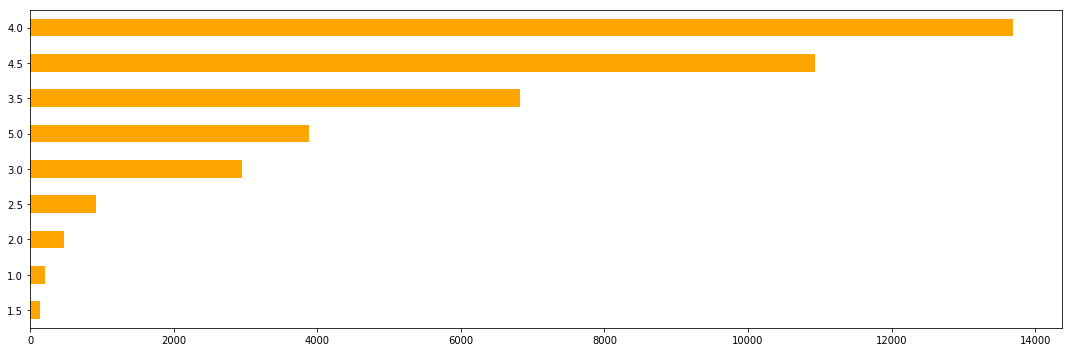

In [35]:
# посмотрим распределение целевой переменной
data[data.is_train]['rating'].value_counts(ascending=True).plot(kind='barh', figsize=(15,5), color=['orange']);
plt.tight_layout()

# целевая переменна кратна 0.5, поэтому результат предсказания нужно округлить до ближайшего кратного

1.0        18407
2.0        8704 
3.0        3330 
9.0        2218 
10.0       1331 
           ...  
67.0       1    
3230.0     1    
9434.0     1    
7118.0     1    
11278.0    1    
Name: rest_id_ranking, Length: 6122, dtype: int64

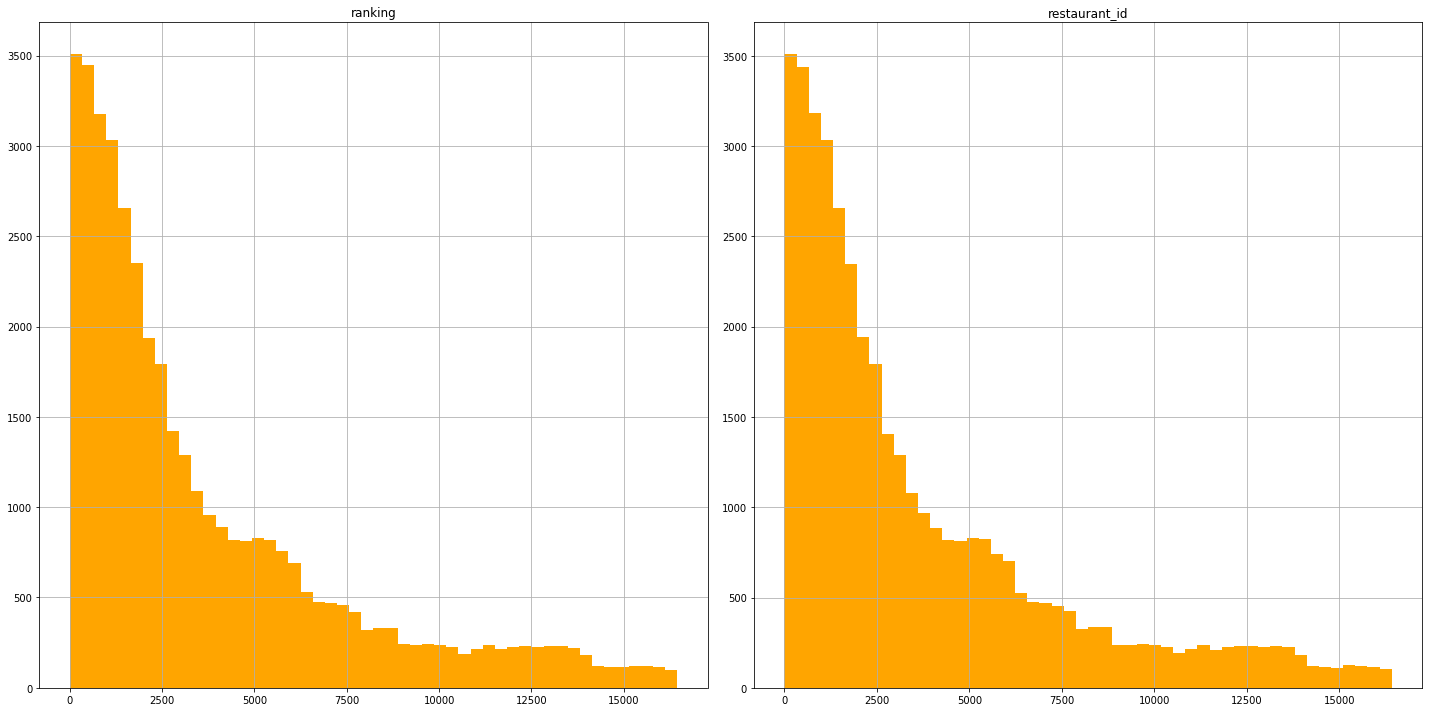

In [36]:
# посмотрим еще раз на  на распределение числовых признаков в датасете
data[data.is_train][['restaurant_id','ranking']].hist(figsize=(20,10), bins=50, color=['orange'], log = False); # прологарифмируем, чтобы лучше было видно выбросы
plt.tight_layout()

# создадим признак rest_id_ranking - разность между ranking и restaurant_id
data['rest_id_ranking'] = abs(data['ranking'] -  data['restaurant_id'])
display(data['rest_id_ranking'].value_counts(dropna=False))

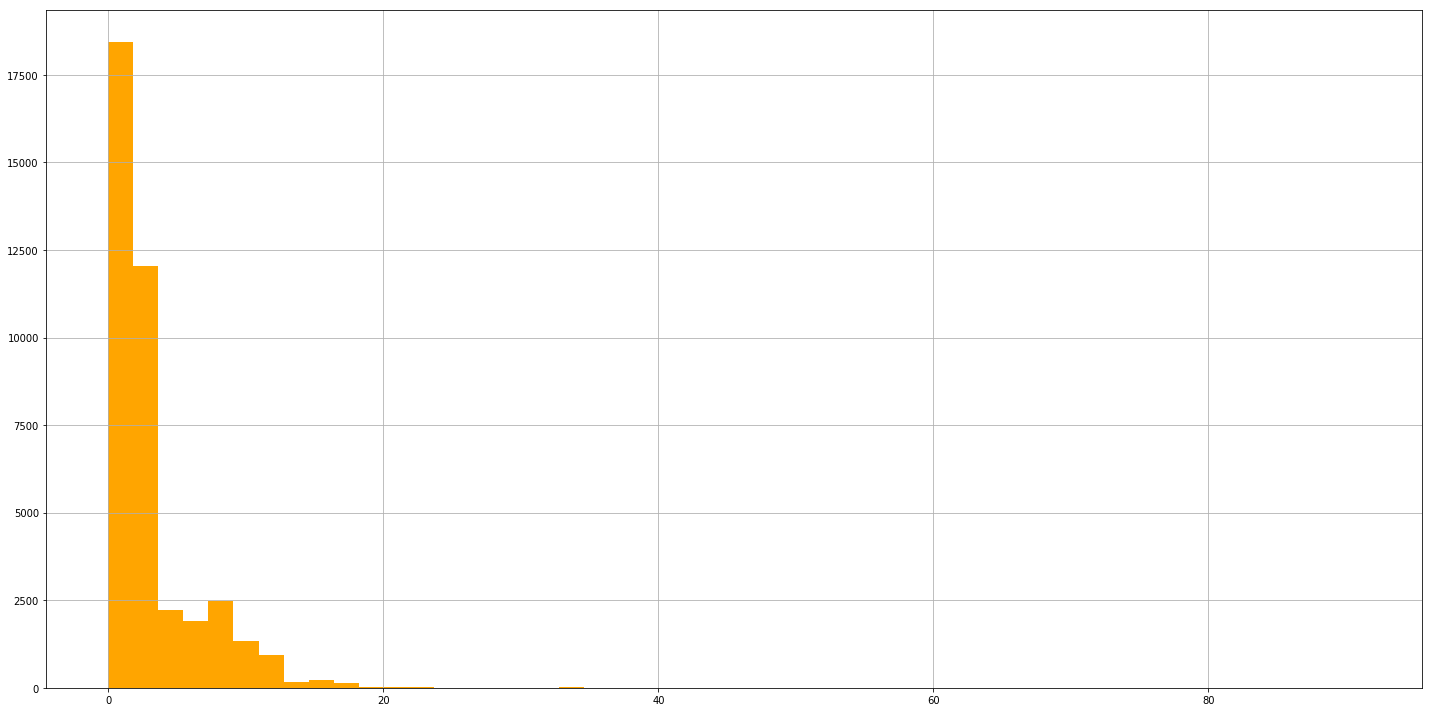

In [37]:
data[data.is_train]['rest_id_ranking'].hist(figsize=(20,10), bins=50, color=['orange'], log = False); # прологарифмируем, чтобы лучше было видно выбросы
plt.tight_layout()

# xxx = data['rest_id_ranking'].value_counts(dropna=False)
# display(xxx)
# display(pd.Series((xxx.index > 0) & (xxx.index < 25)))

# data['rest_id_ranking_bool'] = data['rest_id_ranking'].apply(lambda x: 1 if (x >=0) & (x < 25) else 0) #((xxx.index > 0) & (xxx.index < 25))

# data.sample(5)
# data.drop(['rest_id_ranking'], axis=1, inplace=True)

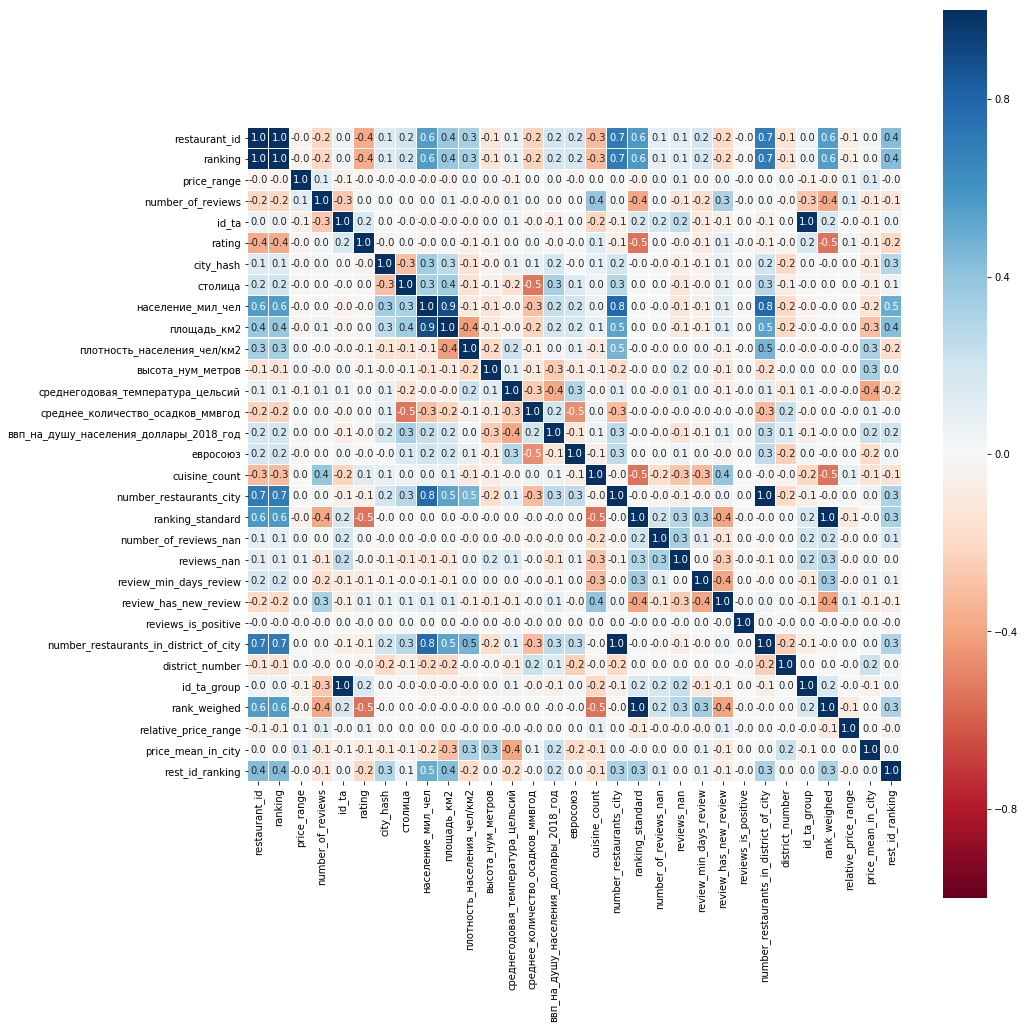

In [38]:
# посмотрим на кореляцию признаков
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data[data.is_train].drop(['is_train'],axis=1).corr(), square=True, annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu", center=0, vmin=-1, vmax=1 );
plt.tight_layout()

In [39]:
# data.info()
# data_short =  data[data.is_train].drop(['restaurant_id','cuisine_style','reviews', 'ranking' ,'ranking','rank_weighed', 'url_ta','is_train',
#                                         'review_1_text', 'review_1_date', 'review_2_text', 'review_2_date', 'id_ta'], axis=1)
# data_short.info()
data_short =  data[data.is_train][['restaurant_id','ranking','rating']]

# sns.pairplot(data_short, diag_kind="hist", hue="rating", height=4);
# plt.tight_layout()

In [40]:
# проверка на статистически значимые различия (пока не буду делать)
from itertools import combinations
from scipy.stats import ttest_ind
def get_stat_dif(dataset, columns, value):
    '''Тест Стьюдента'''
    for column in columns:
        print(column)
        cols = dataset[column].value_counts().index
        
        combinations_all = list(combinations(cols, 2))

        flag = True
        for comb in combinations_all:
            if ttest_ind(dataset[dataset[column] == comb[0]][value],
                         dataset[dataset[column] == comb[1]][value]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
                print('Найдены статистически значимые различия для переменной', column)
                flag = False
                break

        if flag:
            print('Не найдены статистически значимые различия для переменной', column)


# проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. 
 
# object_features = data[data.is_train].select_dtypes(include=['object','bool']).columns
# object_features = ['city', 'cuisine_style', 'reviews', 'url_ta', 'is_train',
#        'cuisine_style_top_n', 'review_1_text', 'review_2_text']
object_features = ['city', 'reviews', 'url_ta', 'cuisine_style_top_n', 'review_1_text', 'review_2_text']
# display(object_features)
# get_stat_dif(data[data.is_train], object_features,'rating')  # после выполнения возвращает список статистически незначимых переменных

# Data Preprocessing

8909.0    7193
2190.0    6108
3251.0    3813
1608.0    3395
3980.0    2705
1379.0    2694
2864.0    2589
1243.0    1816
505.0     1647
1867.0    1443
977.0     1372
179.0     1314
1831.0    1186
1455.0    1145
481.0     1126
966.0     1033
1749.0    1021
1790.0    925 
1173.0    836 
548.0     819 
3090.0    776 
489.0     745 
410.0     685 
236.0     642 
201.0     590 
780.0     554 
673.0     488 
654.0     475 
437.0     380 
115.0     263 
284.0     222 
dtype: int64

,city,cuisine_style,price_range,number_of_reviews,reviews,url_ta,id_ta,is_train,rating,city_hash,страна,столица,население_мил_чел,высота_нум_метров,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,cuisine_style_top_n,number_restaurants_city,ranking_standard,number_of_reviews_nan,reviews_nan,review_1_text,review_1_date,review_2_text,review_2_date,review_min_days_review,review_has_new_review,reviews_is_positive,number_restaurants_in_district_of_city,district_number,id_ta_group,rank_weighed,relative_price_range,price_mean_in_city,rest_id_ranking,person_per_rest
18005,stockholm,[european],2.0,14.0,"[['A must during a Stockholm visit', 'A summer classic'], ['07/02/2017', '10/12/2015']]",/Restaurant_Review-g189852-d6999227-Reviews-Restaurang_Roekeriet-Stockholm.html,6999227,True,4.5,3923032762106093354,sweden,1,0.9,0,619,54628.0,1,1,[european],1033,0.286642,0,0,A must during a Stockholm visit,2017-07-02,A summer classic,2015-10-12,239.0,0,1.0,1033,1,3,0.684414,2.922207,1.969022,1.0,0.935140
36926,madrid,[spanish],2.0,76.0,NaN,/Restaurant_Review-g187514-d2086223-Reviews-Meson_El_Aguila-Madrid.html,2086223,True,3.5,992849973989854412,spain,1,3.2,667,415,50434.0,1,1,[spanish],3813,0.716394,0,1,NaN,NaT,NaN,NaT,290.0,0,0.0,3813,1,1,1.655127,1.208366,1.916077,3.0,0.852609
2164,paris,[italian],2.0,9.0,NaN,/Restaurant_Review-g187147-d6205486-Reviews-Gastronomie_Italienne_Ferrari-Paris_Ile_de_France.html,6205486,True,4.5,-4465655500759980104,france,1,2.1,35,720,66148.0,1,1,[italian],6108,0.555675,0,1,NaN,NaT,NaN,NaT,290.0,0,1.0,6108,1,3,1.272593,1.571594,1.926981,1.0,0.358546
12382,london,"[japanese, fast food, sushi, asian, vegetarian friendly]",2.0,208.0,"[['Average', 'Food quality is deteriorating.'], ['08/02/2017', '05/19/2017']]",/Restaurant_Review-g186338-d2010422-Reviews-YO_Sushi_Westfield-London_England.html,2010422,True,3.0,6142954055757551913,united kingdom,1,8.9,11,690,68496.0,1,5,"[asian, other, vegetarian_friendly]",7193,0.927994,0,0,Average,2017-08-02,Food quality is deteriorating.,2017-05-19,208.0,0,1.0,7193,1,1,2.121507,0.942726,1.861949,12.0,1.238565
11769,london,"[bar, british, pub, brew pub, grill]",2.0,105.0,"[['OK Pub with OK grub', 'Regular pub for cheap eats'], ['10/08/2017', '07/16/2017']]",/Restaurant_Review-g186338-d4444580-Reviews-The_Three_Hammers-London_England.html,4444580,True,3.0,6142954055757551913,united kingdom,1,8.9,11,690,68496.0,1,5,"[pub, other, bar]",7193,0.921973,0,0,OK Pub with OK grub,2017-10-08,Regular pub for cheap eats,2017-07-16,141.0,0,1.0,7193,1,2,2.107744,0.948882,1.861949,11.0,1.238565


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 38 columns):
city                                      50000 non-null object
cuisine_style                             50000 non-null object
price_range                               50000 non-null float64
number_of_reviews                         50000 non-null float64
reviews                                   41886 non-null object
url_ta                                    50000 non-null object
id_ta                                     50000 non-null int64
is_train                                  50000 non-null bool
rating                                    50000 non-null float64
city_hash                                 50000 non-null int64
страна                                    50000 non-null object
столица                                   50000 non-null int64
население_мил_чел                         50000 non-null float64
высота_нум_метров                         50000 non-null int

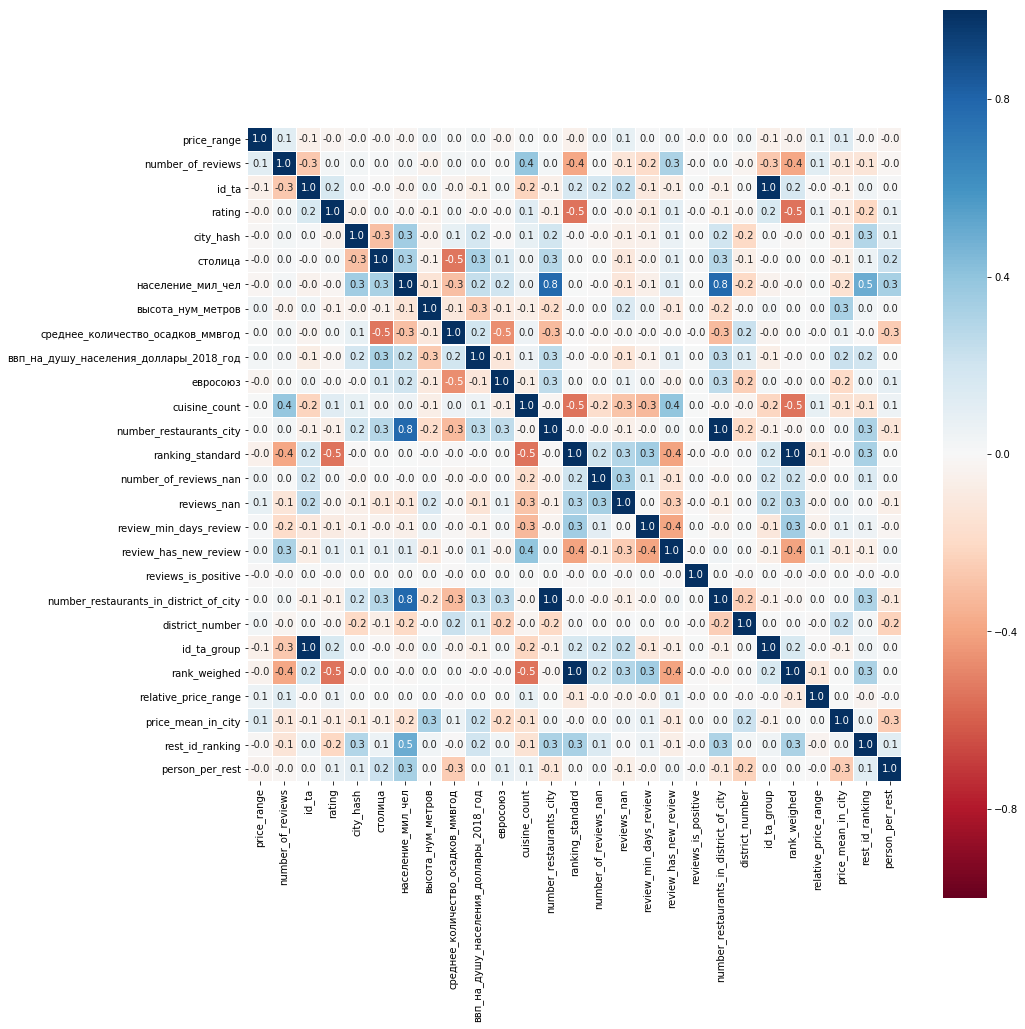

In [41]:
data_preproc = data
# display(data_preproc.info())

# if 'страна' in data_preproc.columns:
data_preproc.drop(['restaurant_id'], axis=1, inplace=True) # удалить - результат не изменяется
data_preproc.drop(['ranking'], axis=1, inplace=True) # удалить - результат не изменяется

# data_preproc.drop(['высота_нум_метров'], axis=1, inplace=True) # удалить - результат не изменяется

# data_preproc.drop(['население_мил_чел'], axis=1, inplace=True) # удалить - результат не изменяется

# data_preproc.drop(['среднее_количество_осадков_ммвгод'], axis=1, inplace=True)
data_preproc.drop(['среднегодовая_температура_цельсий'], axis=1, inplace=True)
# data_preproc.drop(['евросоюз'], axis=1, inplace=True)



# data_preproc.drop(['ranking_standard'], axis=1, inplace=True) 

# data_preproc.drop(['district_number'], axis=1, inplace=True) 

# data_preproc.drop(['rest_id_ranking'], axis=1, inplace=True)  # не удалять - результат немного лучше


# население в 1000 человек
populatuion =  round((data_preproc['площадь_км2'] * data_preproc['плотность_населения_чел/км2']) / 1000)
display(populatuion.value_counts(dropna=False))
# data_preproc['populatuion'] = populatuion

# количество 1000 человек на ресторан
data_preproc['person_per_rest'] = populatuion / data_preproc['number_restaurants_city']
# data_preproc['rest_per_person'] = data_preproc['number_restaurants_city'] / populatuion 

data_preproc.drop(['площадь_км2'], axis=1, inplace=True)
data_preproc.drop(['плотность_населения_чел/км2'], axis=1, inplace=True)

# if 'number_restaurants_city' in data_preproc.columns:
#     data_preproc.drop(['number_restaurants_city'], axis=1, inplace=True)

# data.drop(['id_ta'], axis=1, inplace=True) # не удалять - хороший результат
# data.drop(['id_ta_group'], axis=1, inplace=True) # удалить - результат хуже
display(data_preproc.sample(5))
data_preproc.info()

# посмотрим на кореляцию признаков еще раз
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data_preproc[data_preproc.is_train].drop(['is_train'],axis=1).corr(), square=True, annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu", center=0, vmin=-1, vmax=1 );
plt.tight_layout()

## Convert categorical variable into dummy

In [42]:
# cобираем dummies: city, cuisine_style_top_n

# city
# data_preproc = pd.get_dummies(data_preproc, columns=['city'], dummy_na=False)

# cuisine_style
df_cuisine_style_top_n = pd.get_dummies(data_preproc['cuisine_style_top_n'].apply(pd.Series).stack()).sum(level=0)
df_cuisine_style_top_n = df_cuisine_style_top_n.add_prefix('cuisine_')
# display(df_cuisine_style_top_n)

data_preproc=pd.concat([data_preproc, df_cuisine_style_top_n],  axis=1, sort=False)
# data_preproc.info()

# страна
# if 'страна' in data_preproc.columns: # удалить - результат хуже
#     data_preproc = pd.get_dummies(data_preproc, columns=['страна'], dummy_na=False)

object_features = data_preproc.select_dtypes(include=['object','datetime64']).columns
data_preproc.drop(object_features, axis=1, inplace=True)
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 42 columns):
price_range                               50000 non-null float64
number_of_reviews                         50000 non-null float64
id_ta                                     50000 non-null int64
is_train                                  50000 non-null bool
rating                                    50000 non-null float64
city_hash                                 50000 non-null int64
столица                                   50000 non-null int64
население_мил_чел                         50000 non-null float64
высота_нум_метров                         50000 non-null int64
среднее_количество_осадков_ммвгод         50000 non-null int64
ввп_на_душу_населения_доллары_2018_год    50000 non-null float64
евросоюз                                  50000 non-null int64
cuisine_count                             50000 non-null int64
number_restaurants_city                   50000 non-null int64


#### Запускаем и проверяем что получилось

In [43]:
# Теперь выделим тестовую часть
train_data = data_preproc.query('is_train == 1').drop(['is_train'], axis=1)
test_data = data_preproc.query('is_train == 0').drop(['is_train'], axis=1)

y = train_data.rating.values # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [44]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [45]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 41), (40000, 41), (40000, 40), (32000, 40), (8000, 40))

# Model

In [46]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [47]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [48]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [49]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# d = 1.25
# print(round_to_rating_1(d),round_to_rating_2(d),np.round(d))
# display(y_pred, type(y_pred))

y_pred_corrected_1 =  list(map(lambda x: round_to_rating_1(x), y_pred)) 
y_pred_corrected_2 =  list(map(lambda x: round_to_rating_2(x), y_pred)) 

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE corrected 1:', metrics.mean_absolute_error(y_test, y_pred_corrected_1))
print('MAE corrected 2:', metrics.mean_absolute_error(y_test, y_pred_corrected_2))

#  0.20833666958588765
#  0.20860565494807953 - заполнил пропуски 0 вместо -1 в признаках показывающее число дней между отзывами 
#  0.2069354435130739 - убрал признак разница между двумя отзывами
#  0.21007381458776428 - убрал признаки от максимальной даты
#  0.20755598648817714
#  0.20502877517828097
#  0.203375 - убрал информации о видах кухни
#  0.20295375 - все переделал

# MAE: 0.202403125
# MAE corrected 1: 0.170625
# MAE corrected 2: 0.170875

# подключил оценку отзывов (не дает ощутимого результат)
# MAE: 0.20212937499999997
# MAE corrected 1: 0.169875
# MAE corrected 2: 0.17

# подключил информацию о городах отзывов (но пока это не дало прироста)
# MAE: 0.19791124999999998
# MAE corrected 1: 0.1655
# MAE corrected 2: 0.1655625

# c подгрузкой дополнительной информации о городах
# MAE: 0.19751
# MAE corrected 1: 0.164875
# MAE corrected 2: 0.1654375

# если не подгружать доп инфу по городам
# MAE: 0.19822249999999997
# MAE corrected 1: 0.16525
# MAE corrected 2: 0.1648125

# MAE: 0.19926437499999997
# MAE corrected 1: 0.166625
# MAE corrected 2: 0.1668125

# MAE: 0.19851624999999998
# MAE corrected 1: 0.1666875
# MAE corrected 2: 0.1665


# MAE: 0.198231875
# MAE corrected 1: 0.1655
# MAE corrected 2: 0.1650625

# 2021.04.20
# добавил признак количества ресторанов в каждом районе города
# MAE: 0.19845374999999998
# MAE corrected 1: 0.165375
# MAE corrected 2: 0.1651875

# включил ранк стандарт
# MAE: 0.197371875
# MAE corrected 1: 0.1646875
# MAE corrected 2: 0.1646875

# MAE: 0.197263125
# MAE corrected 1: 0.1653125
# MAE corrected 2: 0.165125

# MAE: 0.19736937499999999
# MAE corrected 1: 0.1663125
# MAE corrected 2: 0.1661875

# MAE: 0.197421875
# MAE corrected 1: 0.16525
# MAE corrected 2: 0.1656875

# MAE: 0.19729500000000003
# MAE corrected 1: 0.1653125
# MAE corrected 2: 0.1644375

# разбил районы на 6 групп лучший результат!!!
# MAE: 0.197048125
# MAE corrected 1: 0.1641875
# MAE corrected 2: 0.1643125

MAE: 0.19835375
MAE corrected 1: 0.1660625
MAE corrected 2: 0.166


In [50]:
# # вычисляем коэффициент детерминации:
# r_2 = metrics.r2_score(y_test, y_pred)
# print(r_2)

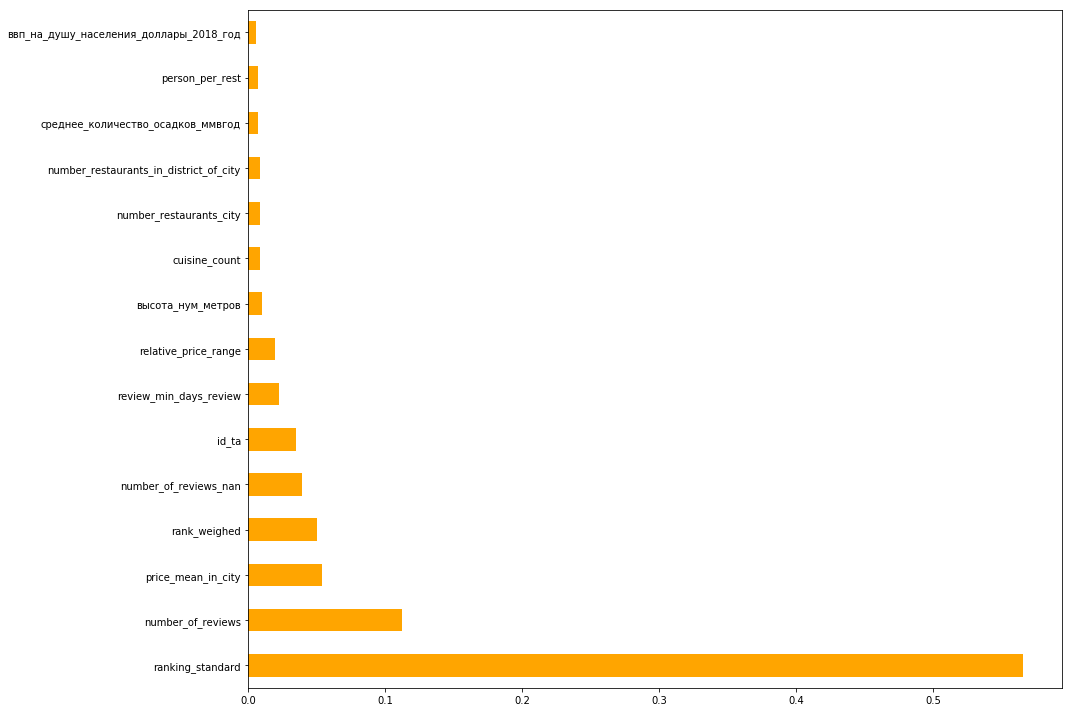

In [51]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(15,10), color=['orange']);
plt.tight_layout()

# Submission

In [52]:
test_data.sample(10)

,price_range,number_of_reviews,id_ta,rating,city_hash,столица,население_мил_чел,высота_нум_метров,среднее_количество_осадков_ммвгод,ввп_на_душу_населения_доллары_2018_год,евросоюз,cuisine_count,number_restaurants_city,ranking_standard,number_of_reviews_nan,reviews_nan,review_min_days_review,review_has_new_review,reviews_is_positive,number_restaurants_in_district_of_city,district_number,id_ta_group,rank_weighed,relative_price_range,price_mean_in_city,rest_id_ranking,person_per_rest,cuisine_asian,cuisine_bar,cuisine_cafe,cuisine_european,cuisine_french,cuisine_gluten_free_options,cuisine_italian,cuisine_mediterranean,cuisine_other,cuisine_pizza,cuisine_pub,cuisine_spanish,cuisine_vegan_options,cuisine_vegetarian_friendly
23970,2.0,21.0,948470,0.0,3410742525631212360,0,1.5,519,1000,48323.0,1,1,1145,0.340942,0,0,139.0,0,1.0,1145,1,0,0.824454,2.425847,1.944105,2345.0,1.270742,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29516,2.0,39.0,2467792,0.0,7731243350169499267,1,1.1,12,919,100479.0,1,3,836,0.864754,0,0,59.0,1,0.0,836,1,1,2.028708,0.985849,1.839713,484.0,1.403110,0,0,0,1,0,0,1,0,0,1,0,0,0,0
15120,2.0,6.0,10063518,0.0,1981604904000603024,1,0.5,2,591,41174.0,1,3,1647,0.646932,0,0,627.0,0,0.0,1647,1,5,1.460231,1.369647,1.822101,4057.0,0.306618,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16590,1.0,51.0,6475388,0.0,-8498242500963475404,1,1.7,108,661,46131.0,1,4,1021,0.310217,0,0,329.0,0,1.0,1021,1,3,0.741430,1.348745,1.807052,1103.0,1.713026,0,1,0,1,0,0,0,0,1,0,1,0,0,0
7580,1.0,4.0,10179503,0.0,6142954055757551913,1,8.9,11,690,68496.0,1,3,7193,0.541020,0,0,370.0,0,1.0,7193,1,5,1.236897,0.808475,1.861949,7118.0,1.238565,0,0,1,0,0,1,0,0,1,0,0,0,0,0
7417,2.0,45.0,9565409,0.0,6142954055757551913,1,8.9,11,690,68496.0,1,5,7193,0.436538,0,0,107.0,0,0.0,7193,1,4,0.998054,2.003900,1.861949,6601.0,1.238565,0,0,0,0,0,0,0,1,1,0,0,0,0,1
14542,2.0,5.0,9758131,0.0,-2966695755353786402,1,0.4,134,683,59394.0,1,1,380,0.915350,0,0,345.0,0,1.0,379,2,4,2.142105,0.933661,1.936842,861.0,1.150000,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33880,2.0,539.0,6475366,0.0,-6267173527456332927,1,0.2,13,807,74574.0,1,6,1314,0.003665,0,0,17.0,1,0.0,961,4,3,0.010654,187.714286,1.907915,6964.0,0.136225,0,0,0,1,0,1,1,0,1,0,0,0,1,1
25150,2.0,125.0,5513637,0.0,4347543484403387382,0,1.8,5,804,60741.0,1,1,1186,0.990859,1,1,290.0,0,1.0,1186,1,2,2.285835,0.874954,1.940135,2036.0,1.543845,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8688,2.0,110.0,3685593,0.0,6142954055757551913,1,8.9,11,690,68496.0,1,5,7193,0.243143,0,0,91.0,0,1.0,7193,1,1,0.555957,3.597399,1.861949,5448.0,1.238565,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [53]:
test_data = test_data.drop(['rating'], axis=1)

In [54]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [55]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [56]:
# скорректируем значения целевой переменной до 0.5 точности
display(predict_submission)
predict_submission_corrected =  np.array(list((map(lambda x: round_to_rating_1(x), predict_submission))))
display(predict_submission_corrected)

array([3.025, 4.4  , 3.075, ..., 3.915, 4.175, 4.41 ])

array([3. , 4.5, 3. , ..., 4. , 4. , 4.5])

In [57]:
sample_submission['Rating'] = predict_submission_corrected
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,3.0
3,id_3,5.0
4,id_4,4.5
5,id_5,4.0
6,id_6,4.0
7,id_7,3.0
8,id_8,3.0
9,id_9,4.0
